# Klasyfikacja stron internetowych pod kątem phishingu
Michał Dąbrowski Filip Mussmann

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pickle
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score

# Wczytanie bazy danych

In [25]:
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shashwatwork/web-page-phishing-detection-dataset")

# List files in the downloaded directory
print("Files in dataset directory:", os.listdir(path))

csv_file = os.path.join(path, "dataset_phishing.csv")
df_full = pd.read_csv(csv_file)

# Process the 'status' column
df_full['status'] = df_full.status.apply(lambda x: 1 if x == 'phishing' else 0)

# Show full DataFrame
pd.set_option('display.max_columns', None)
display(df_full)

df = df_full.drop(columns=['url'])

Files in dataset directory: ['dataset_phishing.csv']


,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.000000,0,0,0,0,0,3,0,0,0,0,0,0,4,4,3,3,3,11,11,6,5.750000,7.00,4.500000,0,0,0,0,0,0,17,0.529412,0.470588,0,0,0,0.875000,0,0.500000,0,0,80.000000,0,100.000000,0.000000,0,0,0,0.000000,0,0,0,0,1,0,45,-1,0,1,1,4,0
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.220779,0.000000,0,0,0,0,0,1,0,0,0,0,1,0,4,4,2,19,2,32,19,32,15.750000,19.00,14.666667,0,0,0,0,0,0,30,0.966667,0.033333,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,80.000000,20.000000,0,0,0,100.000000,0,0,0,1,0,0,77,5767,0,0,1,2,1
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.150794,0.000000,0,0,0,1,0,3,1,0,0,0,1,0,12,2,2,3,2,17,13,17,8.250000,8.40,8.142857,0,0,0,0,0,0,4,1.000000,0.000000,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,100.000000,0,0,0,1,0,0,14,4004,5828815,0,1,0,1
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.000000,0,0,0,0,0,2,0,0,0,0,1,0,1,0,5,5,0,5,5,0,5.000000,5.00,0.000000,0,0,0,0,0,0,149,0.973154,0.026846,0,0,0,0.250000,0,0.250000,0,0,100.000000,0,96.428571,3.571429,0,0,0,62.500000,0,0,0,1,0,0,62,-1,107721,0,0,3,0
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.000000,0,0,0,0,0,2,0,0,0,0,1,0,6,3,3,3,4,11,7,11,6.333333,5.00,7.000000,0,0,0,0,0,0,102,0.470588,0.529412,0,0,0,0.537037,0,0.018519,1,0,76.470588,0,0.000000,100.000000,0,0,0,0.000000,0,0,0,0,1,0,224,8175,8725,0,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,45,17,0,2,0,0,0,0,0,0,0,0,0,4,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.000000,0,0,0,0,0,2,0,0,0,0,1,0,4,4,3,3,8,11,9,11,7.750000,6.00,9.500000,0,0,0,0,0,0,199,0.884422,0.115578,0,0,0,0.043478,0,0.173913,0,1,80.000000,0,21.052632,78.947368,0,0,0,0.000000,0,0,0,0,0,0,448,5396,3980,0,0,6,0
11426,http://www.budgetbots.com/server.php/Server%20...,84,18,0,5,0,1,1,0,0,1,0,0,1,5,0,1,0,0,0,1,1,1,0,0,1,0.023810,0.000000,0,0,1,0,0,3,0,0,0,0,1,0,12,3,3,3,3,10,10,8,5.166667,6.50,4.900000,0,0,0,0,0,0,3,1.000000,0.000000,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,0.000000,0,0,0,1,0,0,211,6728,0,0,1,0,1
11427,https://www.facebook.com/Interactive-Televisio...,105,16,1,2,6,0,1,0,0,1,1,0,0,5,0,1,0,0,0,0,1,0,0,0,0,0.142857,0.000000,0,0,0,0,0,2,0,0,0,0,0,0,13,5,1,3,1,15,8,15

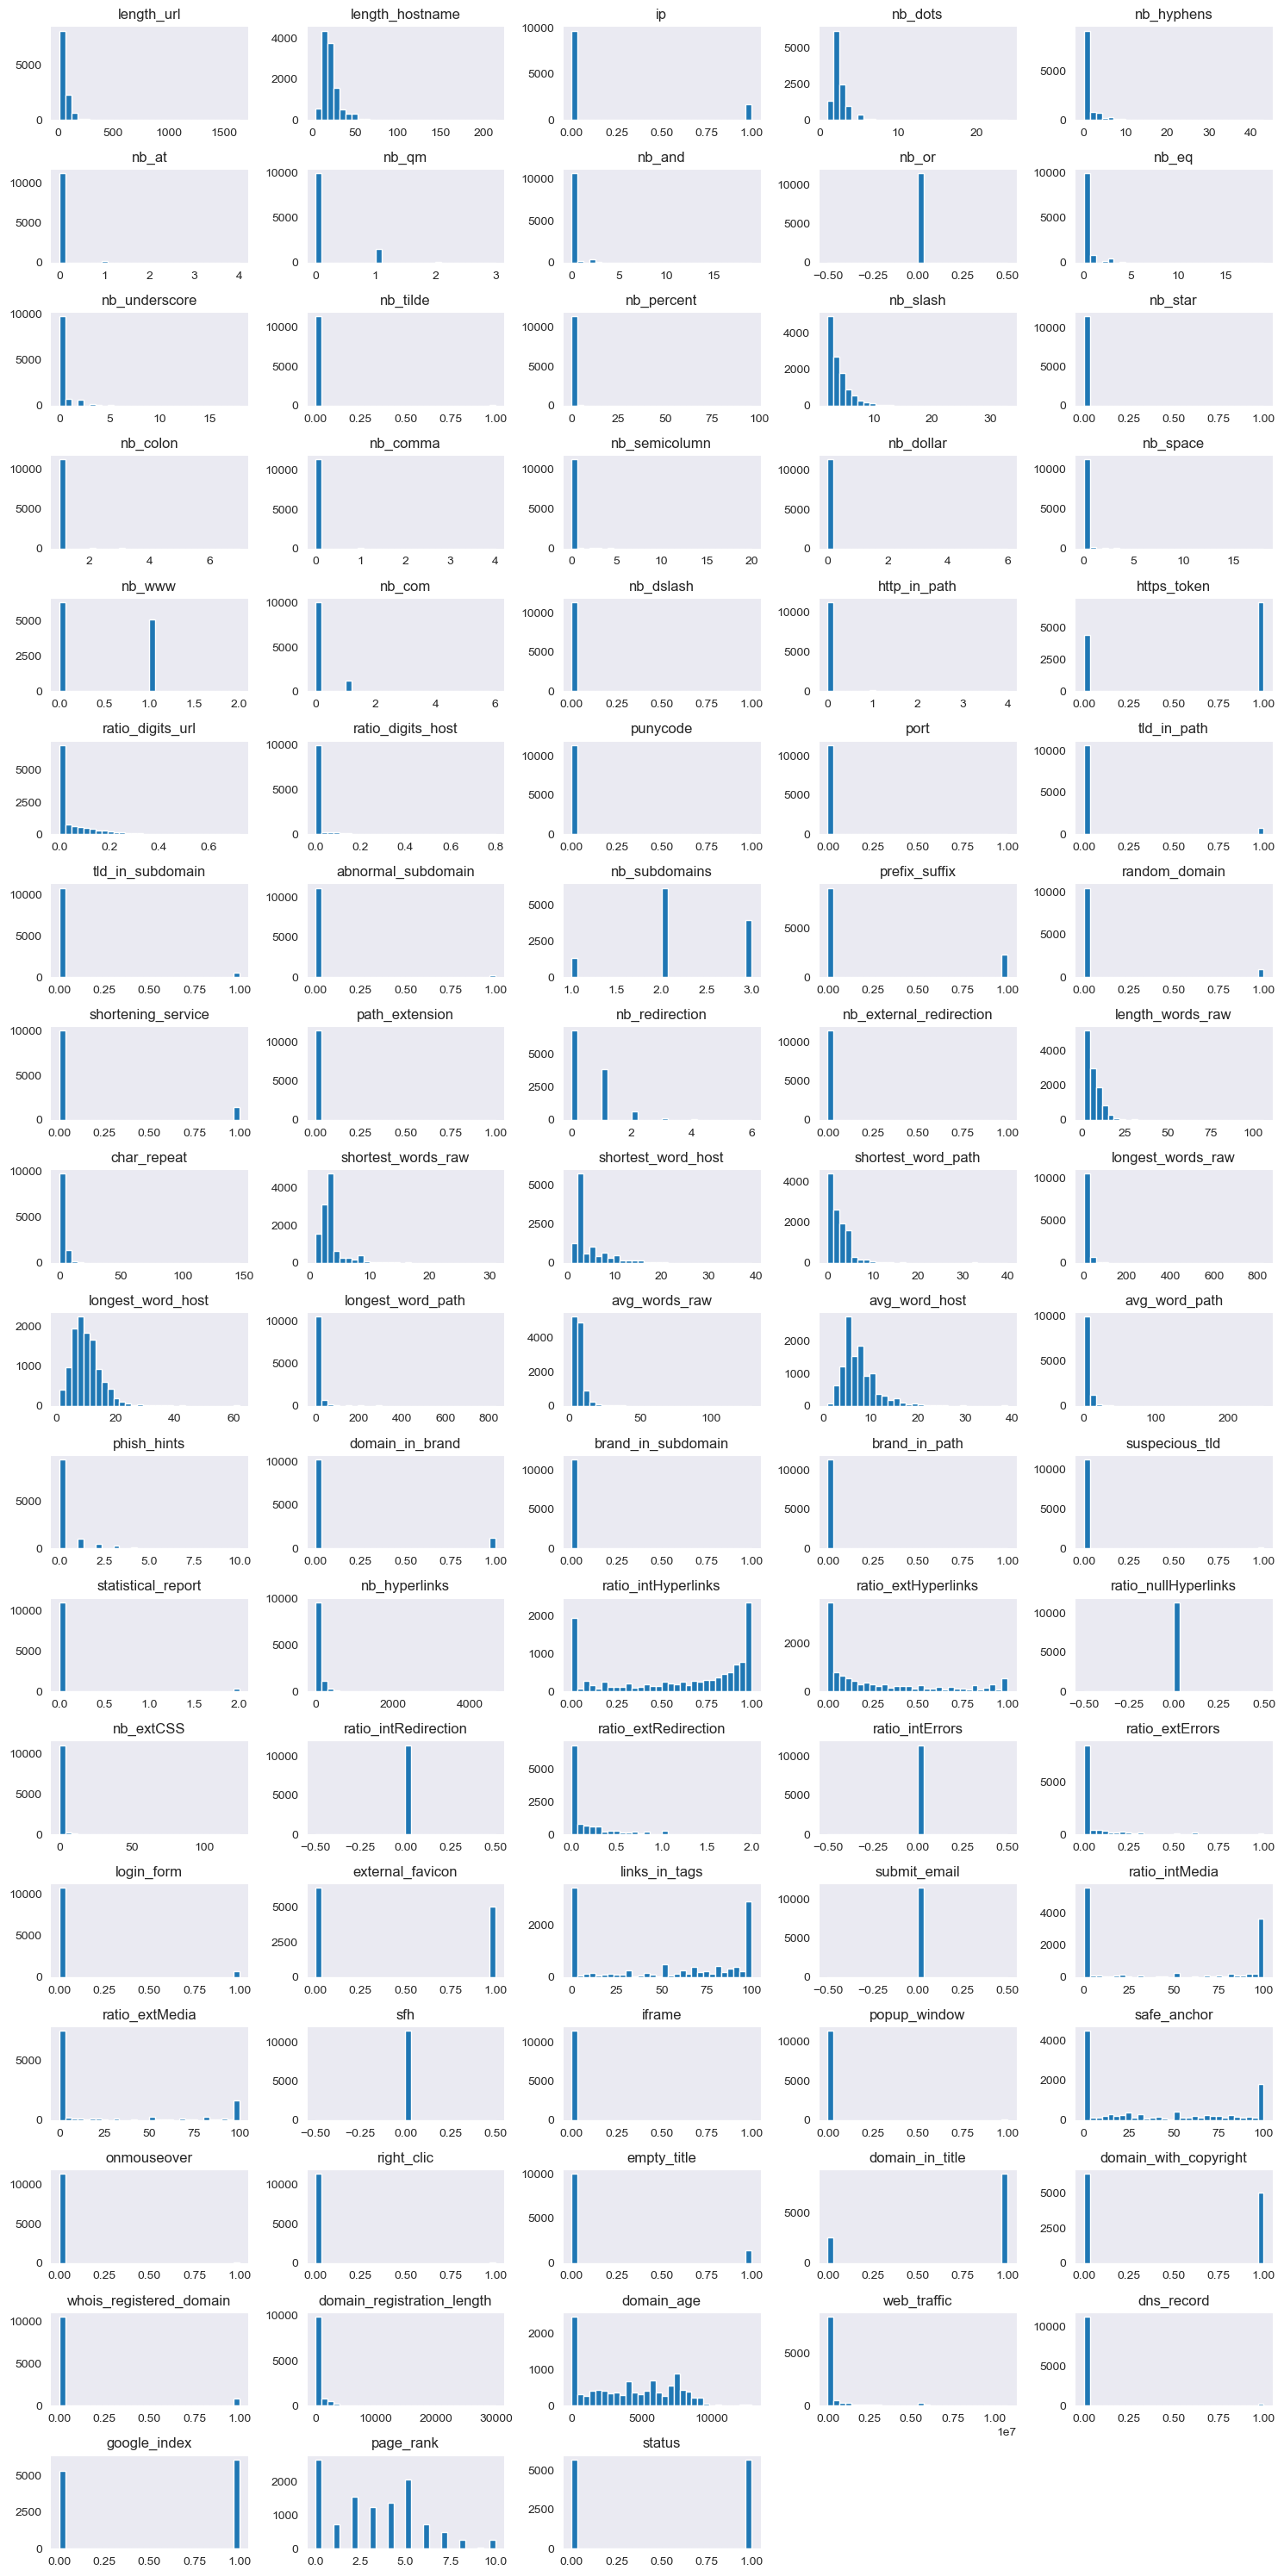

In [26]:
df.hist(
    figsize=(15, 30),       # Increase overall figure size
    bins=30,                # Reduce number of bins for simplicity
    xlabelsize=10,          # Increase label font size
    ylabelsize=10,          # Increase label font size
    layout=(18, 5),         # Manually define subplot layout (rows, columns)
    grid=False              # Optional: turn off grid to reduce clutter
)
plt.tight_layout()

# Praca na zmiennych
Usuwanie i modyfikacja zmiennych

In [4]:
numFeatures_numbers = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                       46, 47, 48, 49, 50, 56, 60, 61, 62, 67, 69, 70, 74, 81, 82, 83, 86]
catFeatures_numbers = [2, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 51, 52, 53, 54, 55, 57, 58, 59, 63, 64, 65, 66, 68, 71, 72, 73, 75, 76, 
                       77, 78, 79, 80, 84, 85]

In [5]:
numFeatures = [df.columns[i] for i in numFeatures_numbers]
catFeatures = [df.columns[i] for i in catFeatures_numbers]

print("Numerical Feature Names:", numFeatures)
print("Categorical Feature Names:", catFeatures)

Numerical Feature Names: ['length_url', 'length_hostname', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'nb_subdomains', 'nb_redirection', 'nb_external_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'nb_hyperlinks', 'nb_extCSS', 'ratio_intRedirection', 'ratio_extRedirection', 'links_in_tags', 'ratio_intMedia', 'ratio_extMedia', 'safe_anchor', 'domain_registration_length', 'domain_age', 'web_traffic', 'page_rank']
Categorical Feature Names: ['ip', 'https_token', 'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'prefix_suff

In [6]:
# zmienne przyjmujące tylko jedną wartość, zerowe odchylenie standardowe
constant_cols = df.columns[df.nunique() == 1].tolist()
print(constant_cols)

['nb_or', 'ratio_nullHyperlinks', 'ratio_intRedirection', 'ratio_intErrors', 'submit_email', 'sfh']


In [7]:
df = df.drop(columns=constant_cols)

# Posprzątanie
catFeatures = [item for item in catFeatures if item not in constant_cols]
numFeatures = [item for item in numFeatures if item not in constant_cols]

# Wartości ujemne zmieniamy na 0
df['domain_age'] = df['domain_age'].apply(lambda x: max(x, 0))
df['domain_registration_length'] = df['domain_registration_length'].apply(lambda x: max(x, 0))

# Poprawa zmiennej statistical_report, kilka przypadków gdzie przyjmują wartość 2
df['statistical_report'] = df['statistical_report'].apply(lambda x: min(x,1))

#Logarytmujemy zmienne
df.length_url = np.log1p(df.length_url)
df.nb_hyperlinks = np.log1p(df.nb_hyperlinks)
df.domain_registration_length = np.log1p(df.domain_registration_length)
df.domain_age = np.log1p(df.domain_age)
df.web_traffic = np.log1p(df.web_traffic)

# Odpowiednio zmieniamy nazwy
df = df.rename(columns={'length_url': 'ln_length_url', 'nb_hyperlinks': 'ln_nb_hyperlinks', 'domain_registration_length': 'ln_domain_registration_length',
                          'domain_age': 'ln_domain_age', 'web_traffic': 'ln_web_traffic',})

In [8]:
slownik = {'length_url': 'ln_length_url', 'nb_hyperlinks': 'ln_nb_hyperlinks', 'domain_registration_length': 'ln_domain_registration_length',
                          'domain_age': 'ln_domain_age', 'web_traffic': 'ln_web_traffic',}
for i in range(len(numFeatures)):
    if numFeatures[i] in slownik:
        numFeatures[i] = slownik[numFeatures[i]]

print(numFeatures)

['ln_length_url', 'length_hostname', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'nb_subdomains', 'nb_redirection', 'nb_external_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'ln_nb_hyperlinks', 'nb_extCSS', 'ratio_extRedirection', 'links_in_tags', 'ratio_intMedia', 'ratio_extMedia', 'safe_anchor', 'ln_domain_registration_length', 'ln_domain_age', 'ln_web_traffic', 'page_rank']


# Ekonometria - logit

In [9]:
# Standaryzacja zmiennych ciągłych
df[numFeatures] = df[numFeatures].apply(lambda x: (x-x.mean())/x.std())

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
# Przygotujmy prosty wrapper
def CVTest(nFolds = 5, randomState=2025, debug=False):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy do zapisywania wyników
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    for train, test in kf.split(df.index.values):
        # Estymacja modelu GLM
        mod = sm.GLM.from_formula(formula="status~"+rhs,
                                  data=df.iloc[train], family=sm.families.Binomial())
        res = mod.fit()
        predsTrain = res.predict()
        preds = res.predict(df.iloc[test])
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df.status.iloc[train], predsTrain)
        testScore = roc_auc_score(df.status.iloc[test], preds)
        
        # Zapisanie wyników dopasowania w foldach
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices


In [11]:
#lista zmiennych objaśniających
features = [col for col in df.columns if col not in ['status']]
#Połączenie zmiennych w formułę
rhs = "+".join(features)

In [12]:
# Zapisanie wyników do zmiennych:
trainResults, testResults, predictions, indices = CVTest(nFolds = 5, randomState=2025)
print(np.mean(trainResults), np.mean(testResults))

0.9880717947145147 0.9858495780287541


In [205]:
resultM1 = {
    "name": "Ekonometria",
    "description":"Pierwszy prosty model ekonometryczny",
    "specification": "status~+rhs",
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [206]:
from sklearn.metrics import roc_curve, roc_auc_score

def plotROCs(results):
    ''' Funkcja, do rysowania szeregu wyników krzywych ROC dla poszczególnych eksperymentów
    results - lista wyników jako 3 elementowe tuple (true, pred, label)
    '''
    
    # Ustalanie wielkości rysunku
    fig, ax = plt.subplots(figsize=(10,9))
        
    for true, pred, label in results:
        # Obliczenie punktów potrzebnych do narysowani akrzywej ROC
        # funkcja roc_curve zwarca trzy serie danych, fpr, tpr oraz poziomy progów odcięcia
        fpr, tpr, thresholds = roc_curve(true, pred)
        # Obliczamy pole powierzchni pod krzywą
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 5)
    
        # Grubość krzywej
        lw = 2

        # Rysujemy krzywą ROC
        ax.plot(fpr, tpr, lw=lw, label=f'{label}: {rocScore}')
    # Rysujemy krzywą 45 stopni jako punkt odniesienia
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    # Dodajemy lekkie marginesy do zakresu aby krzywa nie pokrywała się z osiami
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    plt.show()

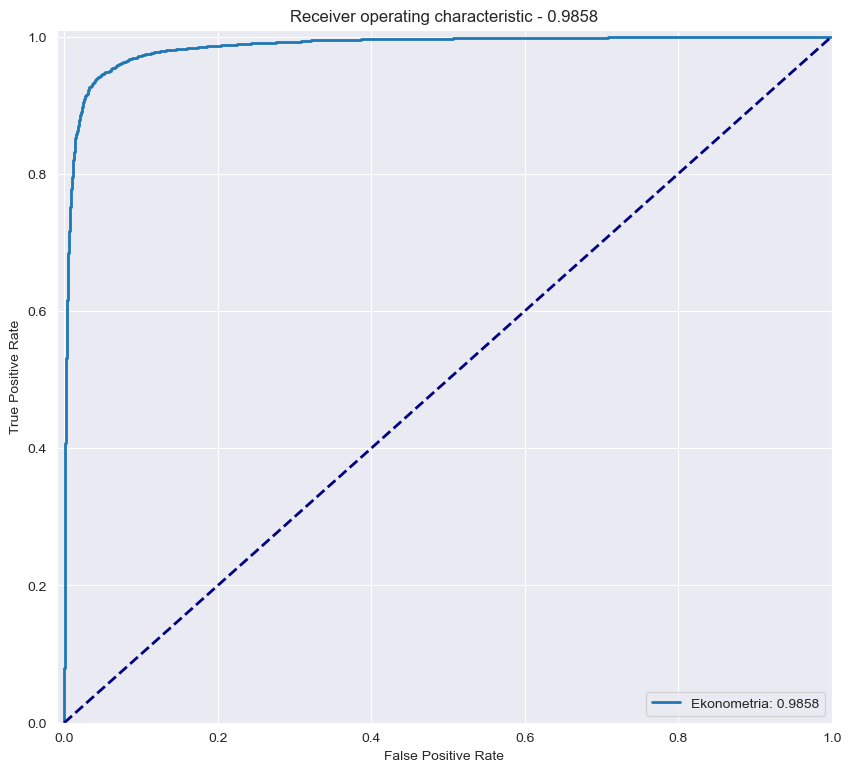

In [207]:
# Przygotowanie danych do rysowania
# Upewniamy się, że dane prawdziwe będą miały posortowany indeks
true = df.status.sort_index()

# Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
pred = pd.Series(sum(resultM1["predictions"], []), index=sum(resultM1["indices"], [])).sort_index()

plotROCs([
    (true, pred, resultM1["name"])  # <- tu wstaw swoje dane, np. pred i true z komórki [68]
])

## Regularyzacja

In [13]:
target = "status"

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn import linear_model

# Przygotujmy prosty wrapper
def CVTestLinearClass(nFolds = 5, randomState=2025, debug=False, features= features, saveModels = False, *args, **kwargs):
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapiszmy wyniki na zbiorze treningowym i testowym:
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy liste modeli do zachowania
    models = []
    for train, test in kf.split(df.index.values):

        # Przygotowanie estymatora
        clf = linear_model.LogisticRegression(*args, **kwargs)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru traeningowego i testowego
        # UWAGA Sklearn zwracałbędzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df[target].iloc[train], predsTrain)
        testScore = roc_auc_score(df[target].iloc[test], preds)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        if saveModels:
            models.append(clf)
        
    return trainResults, testResults, predictions, indices, models

### Lasso

In [212]:
for alpha in [0.001, 0.01, 0.1, 0.25, 0.5, 1, 2, 5]:
    trainResults, testResults, predictions, indices, models = CVTestLinearClass(penalty="l1", solver="liblinear", C=alpha, random_state=2025)
    print("Alpha:", alpha, "Train", np.mean(trainResults), "Test", np.mean(testResults))

Alpha: 0.001 Train 0.9393036548259923 Test 0.9383750732495765
Alpha: 0.01 Train 0.9783357178681193 Test 0.9777594674385248
Alpha: 0.1 Train 0.9860720634344731 Test 0.984938228448512
Alpha: 0.25 Train 0.9873021039919794 Test 0.9859334608148961
Alpha: 0.5 Train 0.9877431094773224 Test 0.9862408283268591
Alpha: 1 Train 0.9879234307458828 Test 0.9863242918566002
Alpha: 2 Train 0.9880095154325099 Test 0.9863423441447056
Alpha: 5 Train 0.9880456448157359 Test 0.9863227201212021


### Ridge

In [213]:
for alpha in [0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10, 50, 100]:
    trainResults, testResults, predictions, indices, models = CVTestLinearClass(penalty="l2", C=alpha, random_state=2025,
                                                                               max_iter = 1000)
    print("Alpha:", alpha, "Train", np.mean(trainResults), "Test", np.mean(testResults))

Alpha: 0.01 Train 0.984021928494817 Test 0.983164530148458
Alpha: 0.1 Train 0.9868143211055779 Test 0.9856043397798565
Alpha: 0.25 Train 0.9872808250862637 Test 0.985888882958658
Alpha: 0.5 Train 0.987532668151724 Test 0.9860412647201737
Alpha: 1 Train 0.9877485252227876 Test 0.986127328814282
Alpha: 2 Train 0.9878881914790346 Test 0.9862237995017058
Alpha: 5 Train 0.9879808301917524 Test 0.9862467487497233
Alpha: 10 Train 0.9880036214581919 Test 0.9862263675939085
Alpha: 50 Train 0.9880329765752632 Test 0.9862491839494234
Alpha: 100 Train 0.9880293886603047 Test 0.9862455051743895


### Elastic Net

In [215]:
for ratio in [0.1, 0.25, 0.5, 0.75, 0.9]:
    for alpha in [0.001, 0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10]:
        trainResults, testResults, predictions, indices, models = CVTestLinearClass(penalty="elasticnet", solver='saga',
                                                                                  C=alpha, l1_ratio = ratio, random_state=2025,
                                                                                   max_iter = 5000)
        print("Ratio", ratio, "Alpha:", alpha, "Train", np.mean(trainResults), "Test", np.mean(testResults))

Ratio 0.1 Alpha: 0.001 Train 0.9726273130473103 Test 0.9721052884334492
Ratio 0.1 Alpha: 0.01 Train 0.9835147981506511 Test 0.9826870840539768


KeyboardInterrupt: 

### Wyniki

Ogólnie najlepszy wynik okazał się dla Lasso z Alpha = 2. \
Train = 0.98801, Test = 0.98634

In [216]:
trainResults, testResults, predictions, indices, models = CVTestLinearClass(penalty="l1", solver="liblinear", C=2, random_state=2025)
print("Alpha: 2", "Train", np.mean(trainResults), "Test", np.mean(testResults))

Alpha: 2 Train 0.9880095154325099 Test 0.9863423441447056


In [218]:
resultM1_2 = {
    "name": "Ekonometria Lasso",
    "description":"Ekonometria, Lasso, Alpha = 2",
    "specification": "status~+rhs",
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [220]:
with open("model_ekonometria_2.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(resultM1_2, fp)

In [222]:
with open("model_ekonometria_1.p", "rb") as fp:
    modelEkonometria = pickle.load(fp)

with open("model_ekonometria_2.p", "rb") as fp:
    modelEkonometria2 = pickle.load(fp)

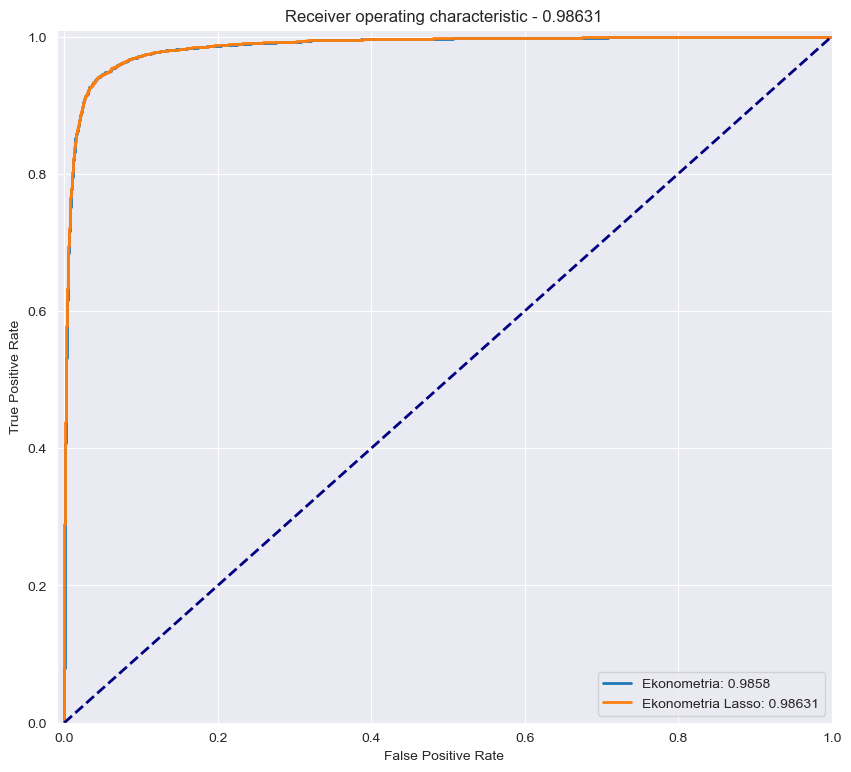

In [225]:
res2plot = []
true = df.status.sort_index()
for result in [modelEkonometria, modelEkonometria2]:
    # scalamy wszystkie predykcje i wszystkie indeksy
    all_preds   = np.concatenate(result["predictions"])
    all_indices = np.concatenate(result["indices"])

    # składamy Series z odpowiednimi indeksami
    pred = pd.Series(all_preds, index=all_indices).sort_index()
    res2plot.append((true, pred, result["name"]))

# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

### Usuwanie zmiennych

Podjęto próbę ręcznego usuwania zmiennych, ale nie poprawiło to wyników

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df, df.status, test_size=0.3, random_state=0)

# Wyestymowanie modelu na próbie treningowej
mod = sm.GLM.from_formula(formula="status ~ " + rhs,
                          data=X_train, family=sm.families.Binomial())
res = mod.fit()
# Wygenerowanie predykcji w zbiorze uczącym i testowym:
preds_tr = res.predict(X_train)
preds_te = res.predict(X_test)

display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 status   No. Observations:                 8001
Model:                            GLM   Df Residuals:                     7919
Model Family:                Binomial   Df Model:                           81
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1089.2
Date:                Tue, 03 Jun 2025   Deviance:                       2178.4
Time:                        09:54:46   Pearson chi2:                 1.72e+04
No. Iterations:                    25   Pseudo R-squ. (CS):             0.6718
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -2.2087    442.583     -0.005      0.996    -869.656     865.239
ln_length_url                    -1.2963      0.356     -3.641      0.000      -1.994      -0.598
length_hostname                   1.0911      0.193      5.666      0.000       0.714       1.468
ip                                1.0194      0.363      2.811      0.005       0.309       1.730
nb_dots                           0.5018      0.225      2.230      0.026       0.061       0.943
nb_hyphens                       -0.7429      0.226     -3.293      0.001      -1.185      -0.301
nb_at                             3.6366   2762.819      0.001      0.999   -5411.389    5418.663
nb_qm                             0.3305      0.152      2.179      0.029       0.033       0.628
nb_and                           -0.5225      0.283     -1.846      0.065      -1.077       0.032
nb_eq                             0.5607      0.235      2.387      0.017       0.100       1.021
nb_underscore                    -0.4340      0.142     -3.063      0.002      -0.712      -0.156
nb_tilde                         -0.0307      0.053     -0.582      0.561      -0.134       0.073
nb_percent                        0.1023      0.190      0.537      0.591      -0.271       0.476
nb_slash                          0.5994      0.199      3.013      0.003       0.210       0.989
nb_star                           0.4588   3262.474      0.000      1.000   -6393.873    6394.791
nb_colon                          0.5546      0.250      2.214      0.027       0.064       1.045
nb_comma                         -0.1678      0.052     -3.221      0.001      -0.270      -0.066
nb_semicolumn                     1.0245      0.358      2.859      0.004       0.322       1.727
nb_dollar                         1.3500   3410.299      0.000      1.000   -6682.713    6685.412
nb_space                         -0.2022      0.064     -3.181      0.001      -0.327      -0.078
nb_www                           -1.0675      0.086    -12.462      0.000      -1.235      -0.900
nb_com                           -0.0186      0.100     -0.186      0.852      -0.214       0.177
nb_dslash                         0.1556      0.182      0.855      0.392      -0.201       0.512
http_in_path                      0.1624      0.121      1.343      0.179      -0.075       0.399
https_token                      -1.0049      0.139     -7.205      0.000      -1.278      -0.732
ratio_digits_url                  0.9594      1.426      0.673      0.501      -1.836       3.755
ratio_digits_host                 7.9213      1.491      5.314      0.000       5.000      10.843
punycode                         22.2212    1.7e+05      0.000      1.000   -3.33e+05    3.33e+05
port                             -4.3582     

In [16]:
# Get a list of variables with p-value > 0.1
insignificant_vars = res.pvalues[res.pvalues > 0.1].index.tolist()
insignificant_vars.pop(0) #Interecpt

print("Variables with p-value > 0.5:")
print(insignificant_vars)


Variables with p-value > 0.5:
['nb_at', 'nb_tilde', 'nb_percent', 'nb_star', 'nb_dollar', 'nb_com', 'nb_dslash', 'http_in_path', 'ratio_digits_url', 'punycode', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'prefix_suffix', 'random_domain', 'path_extension', 'nb_redirection', 'nb_external_redirection', 'length_words_raw', 'shortest_word_path', 'longest_word_host', 'brand_in_subdomain', 'brand_in_path', 'statistical_report', 'nb_extCSS', 'external_favicon', 'ratio_intMedia', 'ratio_extMedia', 'iframe', 'popup_window', 'onmouseover', 'right_clic', 'whois_registered_domain', 'ln_domain_age']


In [17]:
df = df.drop(columns=insignificant_vars)

In [18]:
# lista zmiennych objaśniających 
features = [col for col in df.columns if col not in ['status']]
# Połączenie zmiennych w formułę
rhs = "+".join(features)

# Podzielenie zbioru na treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(df, df.status, test_size=0.3, random_state=2025)
print(X_train.shape, X_test.shape)

# Wyestymowanie modelu na próbie treningowej
mod = sm.GLM.from_formula(formula="status ~ " + rhs,
                          data=X_train, family=sm.families.Binomial())
res = mod.fit()
# Wygenerowanie predykcji w zbiorze uczącym i testowym:
preds_tr = res.predict(X_train)
preds_te = res.predict(X_test)

display(res.summary())

(8001, 48) (3429, 48)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 status   No. Observations:                 8001
Model:                            GLM   Df Residuals:                     7953
Model Family:                Binomial   Df Model:                           47
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1073.2
Date:                Tue, 03 Jun 2025   Deviance:                       2146.4
Time:                        09:54:54   Pearson chi2:                 4.22e+04
No. Iterations:                    10   Pseudo R-squ. (CS):             0.6730
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -2.8234      0.396     -7.129      0.000      -3.600      -2.047
ln_length_url                    -0.5259      0.260     -2.026      0.043      -1.035      -0.017
length_hostname                   1.0262      0.163      6.289      0.000       0.706       1.346
ip                                0.7629      0.286      2.668      0.008       0.202       1.323
nb_dots                           0.4619      0.152      3.042      0.002       0.164       0.760
nb_hyphens                       -0.8745      0.127     -6.898      0.000      -1.123      -0.626
nb_qm                             0.3667      0.123      2.985      0.003       0.126       0.608
nb_and                           -0.1599      0.210     -0.761      0.447      -0.572       0.252
nb_eq                             0.5043      0.214      2.357      0.018       0.085       0.924
nb_underscore                    -0.5137      0.094     -5.457      0.000      -0.698      -0.329
nb_slash                          0.4127      0.129      3.189      0.001       0.159       0.666
nb_colon                          0.4608      0.155      2.964      0.003       0.156       0.765
nb_comma                         -0.1189      0.055     -2.172      0.030      -0.226      -0.012
nb_semicolumn                     1.3144      0.340      3.869      0.000       0.649       1.980
nb_space                         -0.1669      0.042     -3.994      0.000      -0.249      -0.085
nb_www                           -1.0828      0.083    -13.041      0.000      -1.246      -0.920
https_token                      -0.8285      0.134     -6.200      0.000      -1.090      -0.567
ratio_digits_host                 8.3146      1.278      6.505      0.000       5.810      10.820
port                             -4.9095      1.074     -4.570      0.000      -7.015      -2.804
nb_subdomains                    -0.3026      0.116     -2.604      0.009      -0.530      -0.075
shortening_service                1.0433      0.198      5.261      0.000       0.655       1.432
char_repeat                      -0.1982      0.075     -2.637      0.008      -0.345      -0.051
shortest_words_raw                0.3532      0.110      3.198      0.001       0.137       0.570
shortest_word_host                0.8077      0.195      4.150      0.000       0.426       1.189
longest_words_raw                 6.1305      0.862      7.116      0.000       4.442       7.819
longest_word_path                -2.6594      0.902     -2.948      0.003      -4.428      -0.891
avg_words_raw                    -1.3101      0.292     -4.480      0.000      -1.883      -0.737
avg_word_host                    -1.5345      0.240     -6.397      0.000      -2.005      -1.064
avg_word_path                     1.5098     

In [19]:
# Wyniki dla pojedynczej walidacji, zbiór treningowy i testowy
roc_auc_score(y_train, preds_tr), roc_auc_score(y_test, preds_te)

(np.float64(0.988181802275153), np.float64(0.9847805442570501))

In [22]:
for alpha in [0.001, 0.01, 0.1, 0.25, 0.5, 1, 2, 5]:
    trainResults, testResults, predictions, indices, models = CVTestLinearClass(penalty="l1", solver="liblinear", C=alpha, random_state=2025)
    print("Alpha:", alpha, "Train", np.mean(trainResults), "Test", np.mean(testResults))

Alpha: 0.001 Train 0.9392994065110394 Test 0.9383707838878935
Alpha: 0.01 Train 0.9783094051967961 Test 0.977753340376626
Alpha: 0.1 Train 0.9854977153853038 Test 0.9845201099904347
Alpha: 0.25 Train 0.9868170366971871 Test 0.9856945309851899
Alpha: 0.5 Train 0.9872514782974051 Test 0.9860700274497358
Alpha: 1 Train 0.9874422768809044 Test 0.9862484163358245
Alpha: 2 Train 0.9874959734319212 Test 0.9862908240660311
Alpha: 5 Train 0.9875111868046096 Test 0.9863042822672986


In [23]:
for alpha in [0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10, 50, 100]:
    trainResults, testResults, predictions, indices, models = CVTestLinearClass(penalty="l2", C=alpha, random_state=2025,
                                                                               max_iter = 1000)
    print("Alpha:", alpha, "Train", np.mean(trainResults), "Test", np.mean(testResults))

Alpha: 0.01 Train 0.9834020172379387 Test 0.9827958358834588
Alpha: 0.1 Train 0.9861775990362552 Test 0.9852525165788426
Alpha: 0.25 Train 0.9866558429820111 Test 0.9855920361356713
Alpha: 0.5 Train 0.9869400072120763 Test 0.985799704889686
Alpha: 1 Train 0.9871928739411245 Test 0.9860108790171098
Alpha: 2 Train 0.98735703444109 Test 0.9861725911269982
Alpha: 5 Train 0.9874656999625986 Test 0.9862660029967565
Alpha: 10 Train 0.9874926343285125 Test 0.9862624712708831
Alpha: 50 Train 0.9875065845884151 Test 0.9862621516948498
Alpha: 100 Train 0.9875076179245351 Test 0.9862488257347175


# SVM

In [62]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.svm import SVC

# Przygotujmy wrapper - na końcu pojawiają się *args i **kwargs - listy parametrów podawane w postaci słownika
# lub listy.
def CVTestSVM(nFolds = 5, randomState=2025, debug=False, sampleSize = 5000, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy na wyniki:
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = SVC(probability=True, max_iter=-1, random_state=2025, tol=0.001, cache_size=500, *args, **kwargs)
        # Wyświetlenie wywołania funkcji
        if debug:
            print(clf)
        #Zmniejszenie zbioru treningowego
        sampleSize = sampleSize
        X = df.iloc[train].sample(sampleSize)
        # Trenowanie modelu
        clf.fit(X[features], X["status"])

        # Przygotowanie prognoz dla zbioru traeningowego i testowego
        # UWAGA Sklearn zwracałbędzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie statystyka lda każdego foldu
        trainScore = roc_auc_score(df.status.iloc[train], predsTrain)
        testScore = roc_auc_score(df.status.iloc[test], preds)
        
        # Zapisanie wyników do list
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices


In [34]:
testCvalue = []
for c in [1, 2, 5, 10, 25, 50]:
    for kernel in ['linear', 'poly', 'rbf']:
        trainResults, testResults, predictions, indices = CVTestSVM(debug=False, kernel=kernel, C=c)
        print(c, np.mean(testResults))
        testCvalue.append(
            {
            "name":f"SVM {kernel} = {c}",
            "description":"Testy z C i różnymi kernelami",
            "specification":f'kernel="{kernel}" C={c}',
            "trainResults":trainResults.copy(),
            "testResults":testResults.copy(),
            "predictions":predictions.copy(),
            "indices":indices.copy(),
        }
        )

1 0.985152043519971
1 0.9855502461060042
1 0.9888804087421563
2 0.9851595417004477
2 0.9878520370501473
2 0.9897410523056192
5 0.984710602925003
5 0.9882898338418308
5 0.9901234838959937
10 0.9845393682009324
10 0.9880334078975469
10 0.9899993888094281
25 0.9837552334069761
25 0.9867398967744716
25 0.9889799763125593
50 0.9853141381088729
50 0.9848537477170076
50 0.9881623290413002


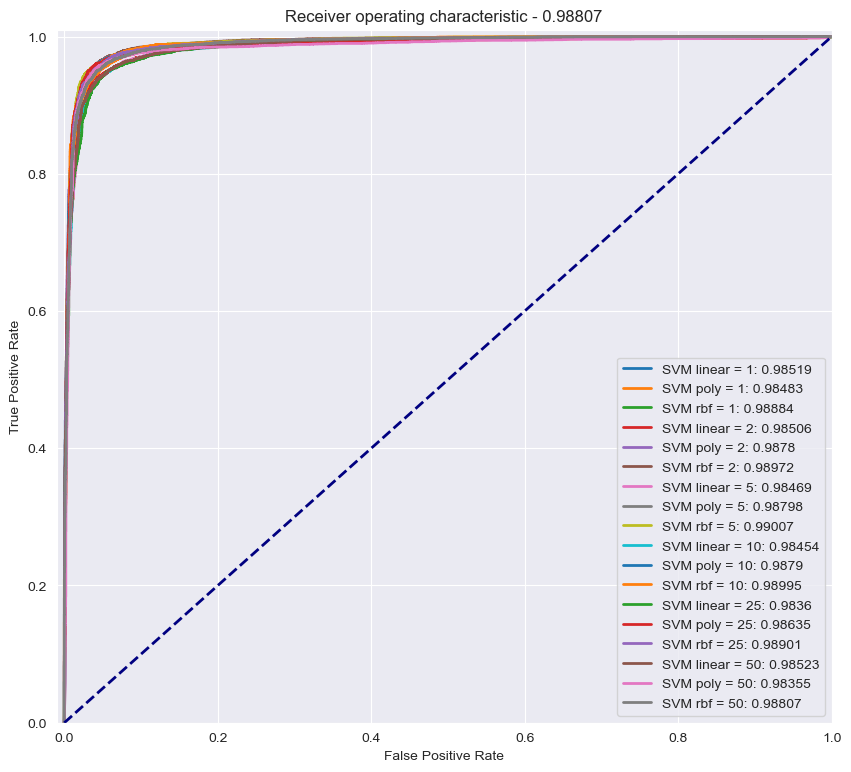

In [35]:
res2plot  = []
true = df.status.sort_index()
for result in testCvalue:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

In [226]:
trainResults, testResults, predictions, indices = CVTestSVM(debug=False, kernel='rbf', C=5)
print(np.mean(trainResults), np.mean(testResults))

0.9945167750420083 0.990488461735992


In [227]:
resultM4 = {
    "name":"SVM",
    "description":"Pierwszy prosty model SVM, z C=5 i kernelem RBF",
    "specification":'kernel="rbf",',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [228]:
# Zapisywanie wyników
with open("model_svm_1.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(resultM4, fp)

In [236]:
with open("model_ekonometria_2.p", "rb") as fp:
    modelEkonometria2 = pickle.load(fp)

with open("model_svm_1.p", "rb") as fp:
    modelSVM = pickle.load(fp)

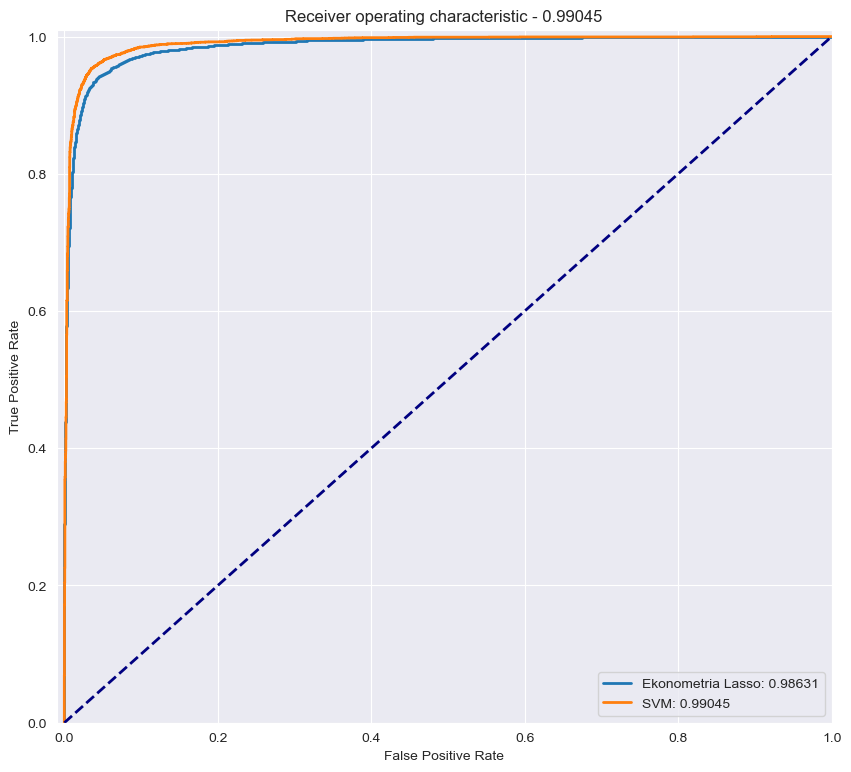

In [237]:
res2plot = []
true = df.status.sort_index()
for result in [modelEkonometria2, modelSVM]:
    # scalamy wszystkie predykcje i wszystkie indeksy
    all_preds   = np.concatenate(result["predictions"])
    all_indices = np.concatenate(result["indices"])

    # składamy Series z odpowiednimi indeksami
    pred = pd.Series(all_preds, index=all_indices).sort_index()
    res2plot.append((true, pred, result["name"]))

# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

### Wykres - dodatek

In [40]:
from sklearn.decomposition import PCA

# Zakładamy, że df zawiera kolumnę "status"
X = df.drop("status", axis=1)
y = df["status"]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Stwórz DataFrame z przekształconymi danymi
dfPCA = pd.DataFrame(X_pca)
dfPCA["status"] = y.values

print(pca.n_components_)  # liczba komponentów zachowujących 90% wariancji
print(sum(pca.explained_variance_ratio_))

2
0.21520722095207773


In [42]:
featuresPCA = [col for col in dfPCA.columns if col not in ['status']]

In [44]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.svm import SVC

# Przygotujmy wrapper - na końcu pojawiają się *args i **kwargs - listy parametrów podawane w postaci słownika
# lub listy.
def CVTestSVM(nFolds = 5, randomState=2025, debug=False, sampleSize = 5000, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy na wyniki:
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    for train, test in kf.split(dfPCA.index.values):
        # Przygotowanie estymatora
        clf = SVC(probability=True, max_iter=-1, random_state=2025, tol=0.001, cache_size=500, *args, **kwargs)
        # Wyświetlenie wywołania funkcji
        if debug:
            print(clf)
        #Zmniejszenie zbioru treningowego
        sampleSize = sampleSize
        X = dfPCA.iloc[train].sample(sampleSize)
        # Trenowanie modelu
        clf.fit(X[featuresPCA], X["status"])

        # Przygotowanie prognoz dla zbioru traeningowego i testowego
        # UWAGA Sklearn zwracałbędzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(dfPCA.iloc[train][featuresPCA])[:,1]
        preds = clf.predict_proba(dfPCA.iloc[test][featuresPCA])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(dfPCA.iloc[test].index.tolist().copy())
        
        # Policzenie statystyka lda każdego foldu
        trainScore = roc_auc_score(dfPCA.status.iloc[train], predsTrain)
        testScore = roc_auc_score(dfPCA.status.iloc[test], preds)
        
        # Zapisanie wyników do list
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices


In [46]:
# trenowanie modelu liniowego (z domyślnym hiperparametrem C)
trainResults, testResults, predictions, indices = CVTestSVM(debug=False, kernel="rbf", gamma=0.5, C=1.0)
# wyświetlenie wyników dla zbioru treningowego i testowego
print(np.mean(trainResults), np.mean(testResults))

0.8335038852766152 0.8313285684322196


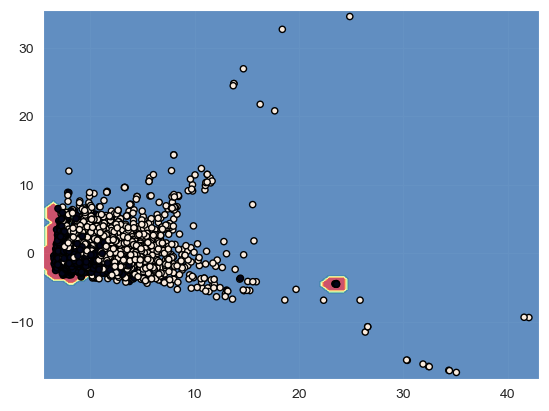

In [47]:
# Load the important packages
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC

#Build the model
svm = SVC(kernel="rbf", gamma=0.5, C=1.0)
# Trained the model
svm.fit(X_pca, dfPCA["status"])

# Plot Decision Boundary
DecisionBoundaryDisplay.from_estimator(
        svm,
        X_pca,
        response_method="predict",
        cmap=plt.cm.Spectral,
        alpha=0.8,
    )

# Scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], 
            c=dfPCA["status"], 
            s=20, edgecolors="k")
plt.show()

# kNN

In [48]:
target = "status"

In [50]:
# Wczytanie potrzebnych bibliotek
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import neighbors
from sklearn.metrics import roc_auc_score

# Przygotujmy wrapper
def CVTestKNN(nFolds = 5, randomState=2025, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy z wynikami
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = neighbors.KNeighborsClassifier(*args, **kwargs)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train]["status"])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie ROC-AUC dla foldów
        trainScore = roc_auc_score(df.status.iloc[train], predsTrain)
        testScore = roc_auc_score(df.status.iloc[test], preds)
        
        # Zapisanie wyników dla foldów
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [51]:
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=50, n_jobs=-1, p=2, debug=True)
print(np.mean(testResults))

KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
Train AUC: 0.9809712547412971 Valid AUC: 0.9712319828944236
KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
Train AUC: 0.9793294493836326 Valid AUC: 0.981175534011796
KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
Train AUC: 0.9794435608918687 Valid AUC: 0.977652491515809
KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
Train AUC: 0.9797933695210954 Valid AUC: 0.9751324371497687
KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
Train AUC: 0.9798325123496798 Valid AUC: 0.9785006251800457
0.9767386141503686


In [52]:
# Ta pętla przechodzi po wartościach k i dla każdej wykonuje walidację krzyżową.
for k in [1, 3, 5, 10, 15, 30, 50, 100, 150, 200]:
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=k, n_jobs=-1, p=2)
    print(k, np.mean(trainResults), np.mean(testResults))

1 1.0 0.9412262433441425
3 0.9967326215331711 0.9714639332041687
5 0.9945472552788196 0.9771523967655618
10 0.9910256243299559 0.9803887810740892
15 0.9884213744715782 0.9806523128631592
30 0.9837020810909062 0.9791186836579143
50 0.9798740293775147 0.9767386141503686
100 0.9740975043436905 0.9720290876700395
150 0.9696233153512915 0.9679994080150667
200 0.9659211742137213 0.9648012740276595


In [53]:
# Ta pętla przechodzi po wartościach k i dla każdej wykonuje walidację krzyżową.
for k in [1, 3, 5, 7, 9, 11, 13, 15]:
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=k, n_jobs=-1, p=2)
    print(k, np.mean(trainResults), np.mean(testResults))

1 1.0 0.9412262433441425
3 0.9967326215331711 0.9714639332041687
5 0.9945472552788196 0.9771523967655618
7 0.9929155588305345 0.9798795230856264
9 0.9915347298565782 0.9804043554839483
11 0.9905168158486599 0.9806067621324626
13 0.9894155754803047 0.9804667018907832
15 0.9884213744715782 0.9806523128631592


In [69]:
# Zmiana dystansu
for k in [1, 3, 5, 7, 9, 11, 13, 15, 19, 31]:
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=k, n_jobs=-1, p=1)
    print(k, np.mean(trainResults), np.mean(testResults))

1 1.0 0.9499881711946646
3 0.9976664322099857 0.9772038990201682
5 0.9962513634839049 0.9825491223330749
7 0.9951311028939728 0.9849650497228737
9 0.9943227020044043 0.9857330429574862
11 0.993640116444763 0.9864266285003638
13 0.9930417840013677 0.9867201910741341
15 0.9924774994982251 0.9866214222987324
19 0.991491291683532 0.9866461463657252
31 0.989239035901152 0.9859666696205531


In [231]:
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=13, n_jobs=-1, p=1)
print(k, np.mean(trainResults), np.mean(testResults))

30 0.9930417840013677 0.9867201910741341


In [232]:
modelkNN = {
    "name":"KNN",
    "description":"Pierwszy dopracowany model KNN, 13 sąsiadów, bez żadnych modyfikacji",
    "specification":'n_neighbors=13, n_jobs=-1, p=1, features=features',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [233]:
import pickle

# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_kNN_1.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelkNN, fp)

In [234]:
with open("model_ekonometria_2.p", "rb") as fp:
    modelEkonometria2 = pickle.load(fp)

with open("model_svm_1.p", "rb") as fp:
    modelSVM = pickle.load(fp)

with open("model_kNN_1.p", "rb") as fp:
    modelkNN = pickle.load(fp)

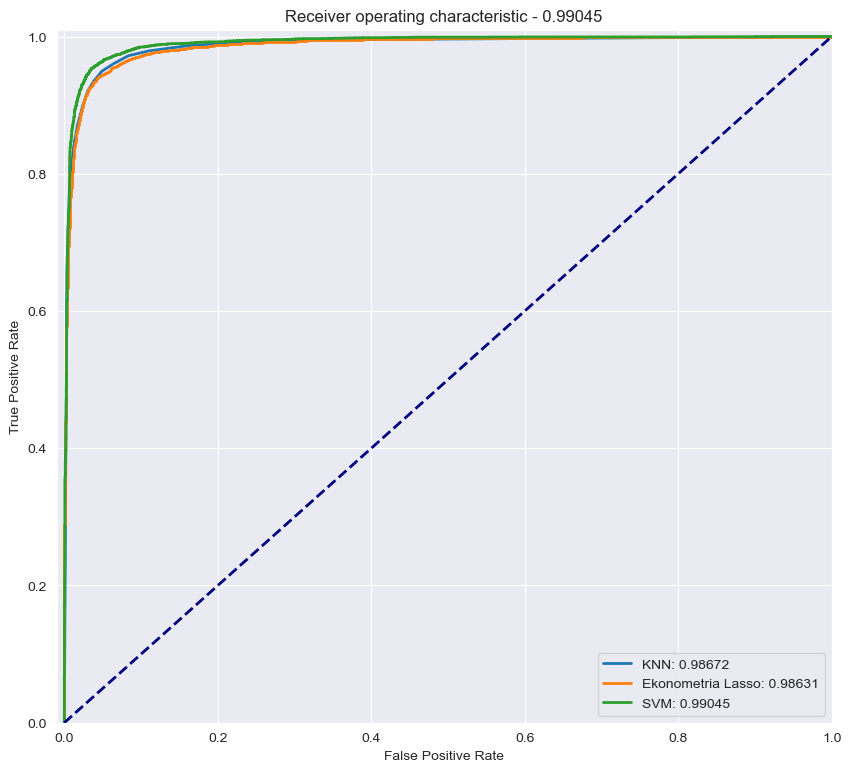

In [235]:
res2plot = []
true = df.status.sort_index()
for result in [modelkNN, modelEkonometria2, modelSVM]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

### Dodatkowa analiza do kNN

In [77]:
from sklearn.decomposition import PCA

# Zakładamy, że df zawiera kolumnę "status"
X = df.drop("status", axis=1)
y = df["status"]

pca = PCA(0.90)  # zachowaj 90%/95% wariancji
X_pca = pca.fit_transform(X)

# Stwórz DataFrame z przekształconymi danymi
dfPCA = pd.DataFrame(X_pca)
dfPCA["status"] = y.values

print(pca.n_components_)  # liczba komponentów zachowujących 90% wariancji


33


In [78]:
featuresPCA = [col for col in dfPCA.columns if col not in ['status']]

In [79]:
# Wczytanie potrzebnych bibliotek
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import neighbors
from sklearn.metrics import roc_auc_score

# Przygotujmy wrapper
def CVTestKNNPCA(nFolds = 5, randomState=2025, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy z wynikami
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(dfPCA.index.values):
        # Przygotowanie estymatora
        clf = neighbors.KNeighborsClassifier(*args, **kwargs)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(dfPCA.iloc[train][featuresPCA], dfPCA.iloc[train]["status"])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(dfPCA.iloc[train][featuresPCA])[:,1]
        preds = clf.predict_proba(dfPCA.iloc[test][featuresPCA])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(dfPCA.iloc[test].index.tolist().copy())
        
        # Policzenie ROC-AUC dla foldów
        trainScore = roc_auc_score(dfPCA.status.iloc[train], predsTrain)
        testScore = roc_auc_score(dfPCA.status.iloc[test], preds)
        
        # Zapisanie wyników dla foldów
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [81]:
# Ta pętla przechodzi po wartościach k i dla każdej wykonuje walidację krzyżową.
for k in [1, 3, 5, 10, 15, 30, 50, 100, 150, 200]:
    trainResults, testResults, predictions, indices = CVTestKNNPCA(n_neighbors=k, n_jobs=-1, p=2)
    print(k, np.mean(trainResults), np.mean(testResults))

1 1.0 0.9312474817586358
3 0.9957938983536134 0.9664612301538336
5 0.9932889605817768 0.9725759859032713
10 0.9889739330804513 0.9766295178294572
15 0.9860768283265268 0.9770643700237299
30 0.9811291334909813 0.9760639508013984
50 0.9772228503763388 0.9739282725267338
100 0.9714854660068039 0.9694512277621502
150 0.9674494539547821 0.965876321469918
200 0.9642884577875698 0.9630002078143388


In [82]:
for k in [1, 3, 5, 7, 9, 11, 13, 15]:
    trainResults, testResults, predictions, indices = CVTestKNNPCA(n_neighbors=k, n_jobs=-1, p=2)
    print(k, np.mean(trainResults), np.mean(testResults))

1 1.0 0.9312474817586358
3 0.9957938983536134 0.9664612301538336
5 0.9932889605817768 0.9725759859032713
7 0.9911991913606292 0.9751774827048614
9 0.9896900215802502 0.9765273360390584
11 0.988272650328583 0.9766488438014118
13 0.9870754282372942 0.976821884090789
15 0.9860768283265268 0.9770643700237299


In [83]:
# Zmiana dystansów
for k in [1, 3, 5, 7, 9, 11, 13, 15]:
    trainResults, testResults, predictions, indices = CVTestKNNPCA(n_neighbors=k, n_jobs=-1, p=1)
    print(k, np.mean(trainResults), np.mean(testResults))

1 1.0 0.9316342303666602
3 0.9958662898815096 0.9674040720456786
5 0.9931270823796648 0.9736860170210498
7 0.9910797154886326 0.9752622680079617
9 0.9893849427566419 0.9762323994413717
11 0.9879928636672346 0.976386017642179
13 0.9867565137932572 0.9763608083745339
15 0.9856113522197338 0.9762760299783437


Żaden z testowanych modeli nie zwrócił lepszego wyniku względem kNN bez PCA

## Wybór zmiennych

In [85]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import neighbors
from sklearn.metrics import roc_auc_score

# Przygotujmy wrapper
def CVTestKNN(nFolds = 5, randomState=2025, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy z wynikami
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = neighbors.KNeighborsClassifier(*args, **kwargs)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train]["status"])

        # Przygotowanie prognoz dla zbioru traeningowego i testowego
        # UWAGA Sklearn zwracałbędzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie ROC-AUC dla foldów
        trainScore = roc_auc_score(df["status"].iloc[train], predsTrain)
        testScore = roc_auc_score(df["status"].iloc[test], preds)
        
        # Zapisanie wyników dla foldów
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices


In [86]:
# Następnie będziemy dodawać każdą zmienną jako osobnego kandydata.
results = []
for feature in features:
    # Estymacja modelu
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=15, n_jobs=-1, p=1, features=[feature])
    print(feature, np.mean(testResults))
    # Zapisanie wyniku jako do obiektu results
    results.append((feature, np.mean(testResults)))

ln_length_url 0.6525705023781809
length_hostname 0.6384303192357769
ip 0.6149889852697951
nb_dots 0.6282049074899562
nb_hyphens 0.6030725322850378
nb_at 0.5214485666814794
nb_qm 0.6022522489516542
nb_and 0.5583389471377082
nb_eq 0.5998452638291819
nb_underscore 0.5275744639889062
nb_tilde 0.5024311564425548
nb_percent 0.5054154453621483
nb_slash 0.6219804320790661
nb_star 0.500697795248337
nb_colon 0.5118505381562758
nb_comma 0.5004472990396122
nb_semicolumn 0.5213095614404482
nb_dollar 0.5009587149959408
nb_space 0.5005987870971094
nb_www 0.7265070166745564
nb_com 0.5526937498207791
nb_dslash 0.505889904275173
http_in_path 0.5086135772425958
https_token 0.5559288662930559
ratio_digits_url 0.699812679315012
ratio_digits_host 0.5967116520492651
punycode 0.5002604691980459
port 0.5004325869932099
tld_in_path 0.5195756038130425
tld_in_subdomain 0.5455202902426679
abnormal_subdomain 0.5186442131344773
nb_subdomains 0.6022515300722631
prefix_suffix 0.5860494774018841
random_domain 0.5054312

In [87]:
results = sorted(results, key=lambda x: x[1], reverse=True)
results

[('google_index', np.float64(0.8646792046740952)),
 ('ln_web_traffic', np.float64(0.8577142142216545)),
 ('ln_nb_hyperlinks', np.float64(0.8392675544002884)),
 ('ln_domain_age', np.float64(0.8380858340052019)),
 ('ratio_intHyperlinks', np.float64(0.8287873137882251)),
 ('ratio_extHyperlinks', np.float64(0.8276412203059241)),
 ('page_rank', np.float64(0.8232884445601005)),
 ('safe_anchor', np.float64(0.777152238976489)),
 ('ln_domain_registration_length', np.float64(0.7372395914705392)),
 ('links_in_tags', np.float64(0.7356834080172447)),
 ('nb_www', np.float64(0.7265070166745564)),
 ('ratio_extRedirection', np.float64(0.7263878622665363)),
 ('longest_word_path', np.float64(0.7032707556003093)),
 ('ratio_digits_url', np.float64(0.699812679315012)),
 ('shortest_word_host', np.float64(0.6830262564755099)),
 ('char_repeat', np.float64(0.6827711908241227)),
 ('ratio_intMedia', np.float64(0.6734901308905065)),
 ('avg_word_host', np.float64(0.6677867380535211)),
 ('avg_word_path', np.float64(

# Naive Bayes

In [88]:
# Wczytanie potrzebnych bibliotek
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score

# Przygotujmy wrapper
def CVTestNBGaussian(nFolds = 5, randomState=2025, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Lista z wynikami
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = GaussianNB(*args, **kwargs)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train]["status"])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie ROC-AUC dla foldów
        trainScore = roc_auc_score(df["status"].iloc[train], predsTrain)
        testScore = roc_auc_score(df["status"].iloc[test], preds)
        
        # Zapisanie wyników dla foldów
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [238]:
trainResults, testResults, predictions, indices = CVTestNBGaussian(debug=True)
print(np.mean(testResults))

GaussianNB()
Train AUC: 0.9299294132550984 Valid AUC: 0.9255352959511339
GaussianNB()
Train AUC: 0.9304257689761146 Valid AUC: 0.9301867366817591
GaussianNB()
Train AUC: 0.9287659496336121 Valid AUC: 0.9393157374566794
GaussianNB()
Train AUC: 0.9300934578097945 Valid AUC: 0.9174725173775913
GaussianNB()
Train AUC: 0.9278697274260274 Valid AUC: 0.9233277199928902
0.9271676014920107


In [239]:
modelNB = {
    "name":"NB",
    "description":"Prosty ,odel Naive Bayes",
    "specification":'',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [240]:
import pickle

# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_NB_1.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelNB, fp)

In [241]:
with open("model_ekonometria_2.p", "rb") as fp:
    modelEkonometria2 = pickle.load(fp)

with open("model_svm_1.p", "rb") as fp:
    modelSVM = pickle.load(fp)

with open("model_kNN_1.p", "rb") as fp:
    modelkNN = pickle.load(fp)

with open("model_NB_1.p", "rb") as fp:
    modelNB = pickle.load(fp)

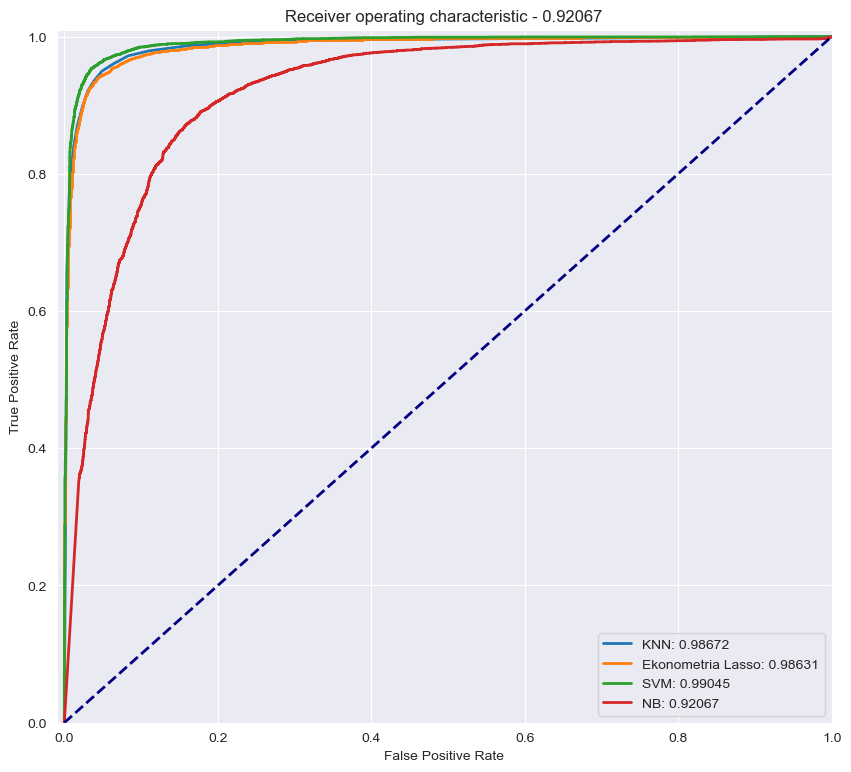

In [242]:
res2plot = []
true = df.status.sort_index()
for result in [modelkNN, modelEkonometria2, modelSVM, modelNB]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

Dodatek: Naive Bayes z PCA

In [97]:
from sklearn.decomposition import PCA

# Zakładamy, że df zawiera kolumnę "status"
X = df.drop("status", axis=1)
y = df["status"]

# Liczby komponentów, które chcesz przetestować
components_list = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]

# Słownik do przechowania wynikowych DataFrame'ów
dfPCA_dict = {}

for n in components_list:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)

    df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
    df_pca["status"] = y.values

    dfPCA_dict[f"dfPCA_{n}"] = df_pca

    print(f"Utworzono dfPCA_{n} z {pca.n_components_} komponentami")


Utworzono dfPCA_20 z 20 komponentami
Utworzono dfPCA_25 z 25 komponentami
Utworzono dfPCA_30 z 30 komponentami
Utworzono dfPCA_35 z 35 komponentami
Utworzono dfPCA_40 z 40 komponentami
Utworzono dfPCA_45 z 45 komponentami
Utworzono dfPCA_50 z 50 komponentami
Utworzono dfPCA_55 z 55 komponentami
Utworzono dfPCA_60 z 60 komponentami
Utworzono dfPCA_65 z 65 komponentami
Utworzono dfPCA_70 z 70 komponentami


In [99]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score

def CVTestNBGaussianPCA(df, features, nFolds=5, randomState=2025, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    testResults = []
    trainResults = []
    predictions = []
    indices = []

    for train, test in kf.split(df.index.values):
        clf = GaussianNB(*args, **kwargs)
        if debug:
            print(clf)

        # Trening na danych treningowych
        clf.fit(df.iloc[train][features], df.iloc[train]["status"])

        # Predykcje
        predsTrain = clf.predict_proba(df.iloc[train][features])[:, 1]
        preds = clf.predict_proba(df.iloc[test][features])[:, 1]

        predictions.append(preds.tolist())
        indices.append(df.iloc[test].index.tolist())

        # AUC
        trainScore = roc_auc_score(df["status"].iloc[train], predsTrain)
        testScore = roc_auc_score(df["status"].iloc[test], preds)

        trainResults.append(trainScore)
        testResults.append(testScore)

        if debug:
            print(f"Train AUC: {trainScore:.4f}, Valid AUC: {testScore:.4f}")

    return trainResults, testResults, predictions, indices


In [100]:
for n in components_list:
    df_pca = dfPCA_dict[f"dfPCA_{n}"]
    featuresPCA = df_pca.columns[:-1]  # Wszystkie poza "status"
    trainRes, testRes, preds, idx = CVTestNBGaussianPCA(df_pca, featuresPCA)
    print(f"{n} komponentów – średni AUC: {np.mean(testRes):.5f}")


20 komponentów – średni AUC: 0.85720
25 komponentów – średni AUC: 0.85589
30 komponentów – średni AUC: 0.85461
35 komponentów – średni AUC: 0.86384
40 komponentów – średni AUC: 0.85759
45 komponentów – średni AUC: 0.86273
50 komponentów – średni AUC: 0.86695
55 komponentów – średni AUC: 0.86460
60 komponentów – średni AUC: 0.85729
65 komponentów – średni AUC: 0.85805
70 komponentów – średni AUC: 0.85982


Dodanie PCA do NB pogorszyło wyniki

# Random Forest

In [110]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Przygotujmy wrapper
def CVTestRFClass(nFolds = 5, randomState=2025, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train]["status"])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())

        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())

        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score(df["status"].iloc[train], predsTrain)
        testScore = roc_auc_score(df["status"].iloc[test], preds)

        # Zapisanie wyników do listy
        trainResults.append(trainScore)
        testResults.append(testScore)

        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)

    return trainResults, testResults, predictions, indices

10 0.9891622600669345
25 0.9918171164580235
50 0.9930927786692075
100 0.9936882446316073
200 0.9938581943282901
500 0.9938942014708758
1000 0.9939330265751485


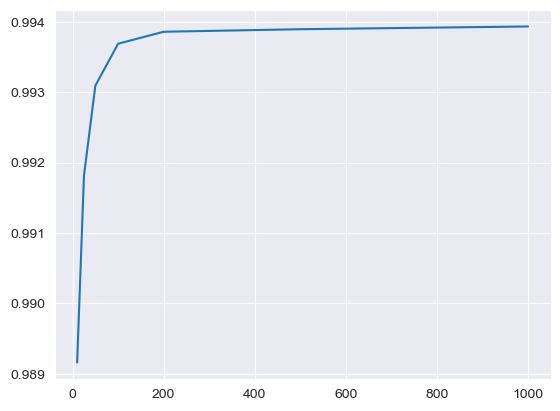

In [145]:
# Pętla po parametrze n_estimators
results = []
for k in [10, 25, 50, 100, 200, 500, 1000]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=k)
    print(k, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot([10, 25, 50, 100, 200, 500, 1000], results)
plt.show()

Przy ok. 200 drzewach warto się zatrzymać

2 0.9774432603477325
4 0.9832960400542451
6 0.987419496671569
8 0.9901239424766197
10 0.9918528959554264
12 0.992866542817494
14 0.9933324517885527
16 0.9935570956444769
18 0.9937630484570604
20 0.9937752355170721


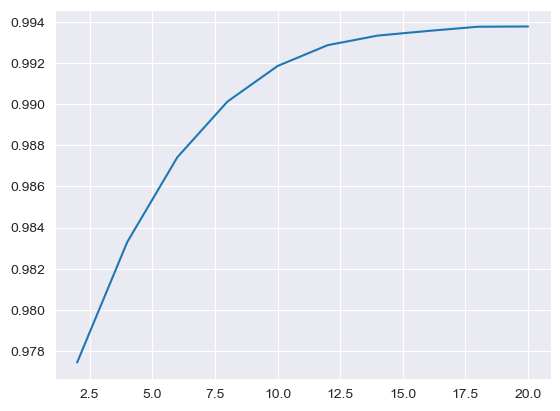

In [147]:
results = []
for k in range(2,22,2):
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=200, max_depth=k)
    print(k, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(range(2,22,2), results)
plt.show()

Optymalny wynik będzie przy maksymalnej głębokości koło 18


2 0.9928767719129752
4 0.9936123066315113
6 0.9938290526787059
8 0.9937479463519121
10 0.9937721352596343
12 0.9936616514822834
14 0.9935119947010438
16 0.9935272725895642
18 0.9933283135140062
20 0.9933655264064267
22 0.99316201064653
24 0.9928975571532493
26 0.9927310042428846
28 0.9928376558309668


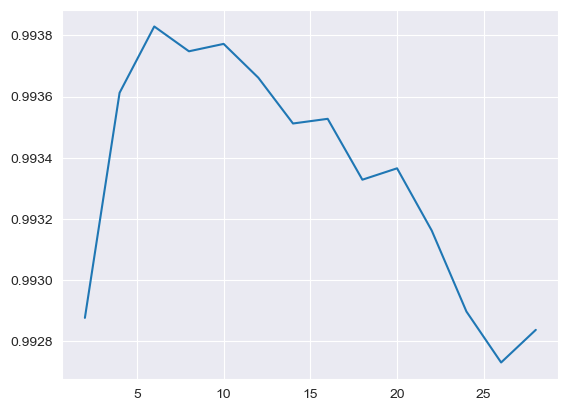

In [148]:
results = []
for k in range(2, 30, 2):
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=200, max_depth=18,
                                                                    max_features=k)
    print(k, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(range(2, 30, 2), results)
plt.show()

Przy ok. 6 zmiennych w drzewie otrzymujemy najlepsze wartosci

2 0.9938290526787059
4 0.9934221797426585
6 0.993261587912543
8 0.9929980805412683
10 0.9930395414225565
15 0.9925403187007925
20 0.9922849053935675
30 0.9916469414024759


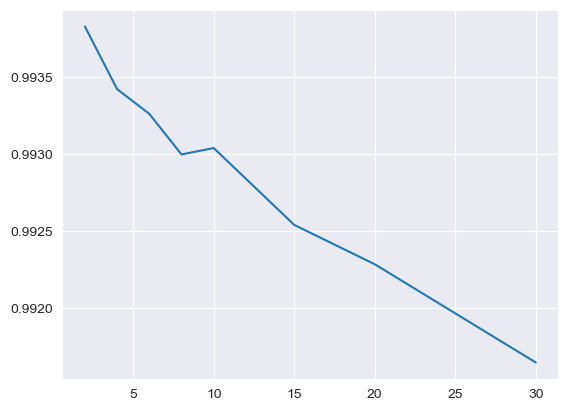

In [149]:
results = []
for k in [2, 4, 6, 8, 10, 15, 20, 30]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=200, max_depth=18,
                                                                    max_features=6,
                                                                    min_samples_split=k)
    print(k, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot([2, 4, 6, 8, 10, 15, 20, 30], results)
plt.show()

Przy minimalnej liczbie obserwacji do rozgałęzienia równej 2 mamy do wyboru tylko min_samples_leaf = 1:

In [118]:
trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=200, max_depth=18,
                                                                    max_features=6,
                                                                    min_samples_split=2, min_samples_leaf=1)
print(1, np.mean(testResults))

1 0.9938290526787059


Tak więc nasz "dobrany ręcznie" model ma AUC ~0.99383

Spróbujmy teraz znaleźć lepsze parametry poprzez random search:

In [151]:
import random
random.seed(2025)

results=[]
paramList = []
for x in range(100):
    params = (random.randint(10, 500), random.randint(2, 40), random.randint(2, 30), random.randint(2, 50)) #, random.randint(1, 10))
    trainResults, testResults, predictions, indices = CVTestRFClass(
        n_estimators=params[0],
        max_depth = params[1],
        max_features = params[2],
        min_samples_split=params[3]
        #,
        #min_samples_leaf=params[4]
    )
    if x % 10 == 0:
        print(x)
    results.append(np.mean(testResults))
    paramList.append(params)

maxRes = []
for i in range(1, len(paramList)):
    maxRes.append(max(results[0:i]))
imp = list(zip(results, paramList))
imp.sort(reverse=True)
for row in imp[0:10]:
    print(row)


0
10
20
30
40
50
60
70
80
90
(np.float64(0.9938430372555743), (467, 21, 6, 3))
(np.float64(0.993477071661917), (331, 15, 8, 4))
(np.float64(0.9933493291461097), (261, 36, 13, 7))
(np.float64(0.9932336305952154), (88, 17, 10, 3))
(np.float64(0.9931652994228228), (288, 31, 11, 9))
(np.float64(0.9931554829254872), (477, 19, 6, 9))
(np.float64(0.9930861080065846), (186, 18, 10, 9))
(np.float64(0.9930718688766861), (308, 29, 8, 11))
(np.float64(0.9929992847786988), (159, 27, 2, 5))
(np.float64(0.9929582250526), (494, 13, 18, 2))


Najlepszy model ma AUC ~0,99384 - to nieznacznie lepiej niż nasz wcześniejszy model, jednak kosztem znaczącego zwiększenia ilości drzew, stąd wydaje się, że lepiej pozostać przy pierwszym modelu.

Spróbujmy jeszcze trochę innego podejścia - będziemy rozważać kombinacje wcześniej rozważanych wartości hiperparametrów. Wylosujemy 100 kombinacji i zestawimy AUC:

In [146]:
import numpy as np
import random
from itertools import product

random.seed(2025)

# 1) Definicja siatki parametrów
n_estimators       = [10, 25, 50, 100, 200, 500]
max_depth          = list(range(2, 20, 2))
max_features       = list(range(2, 18, 4))
min_samples_split  = [2, 4, 6, 8, 10, 15, 20, 30]
#min_samples_leaf   = [1, 2, 3, 4, 5]

# 2) Utworzenie listy wszystkich kombinacji
param_grid = list(product(
    n_estimators,
    max_depth,
    max_features,
    min_samples_split
    #,
    #min_samples_leaf
))

# 3) Wylosowanie 100 unikalnych kombinacji (jeśli jest ich więcej niż 100)
sampled_params = random.sample(param_grid, 100) if len(param_grid) > 100 else param_grid  # [1]

results = []
total   = len(sampled_params)

# 4) Iterowanie po wylosowanej próbce parametrów
for idx, (n_est, depth, feat, split) in enumerate(sampled_params, start=1):  # , leaf
    trainR, testR, preds, indices = CVTestRFClass(
        n_estimators      = n_est,
        max_depth         = depth,
        max_features      = feat,
        min_samples_split = split
        #,
        #min_samples_leaf  = leaf
    )
    score = np.mean(testR)
    results.append((score, (n_est, depth, feat, split))) #, leaf

    if idx % 10 == 0 or idx == total:
        print(f"Przetworzono {idx}/{total} kombinacji")

# 5) Sortowanie i wyświetlenie top 10
results.sort(key=lambda x: x[0], reverse=True)
for score, params in results[:10]:
    print(f"score={score:.4f}\tparams={params}")

Przetworzono 10/100 kombinacji
Przetworzono 20/100 kombinacji
Przetworzono 30/100 kombinacji
Przetworzono 40/100 kombinacji
Przetworzono 50/100 kombinacji
Przetworzono 60/100 kombinacji
Przetworzono 70/100 kombinacji
Przetworzono 80/100 kombinacji
Przetworzono 90/100 kombinacji
Przetworzono 100/100 kombinacji
score=0.9933	params=(500, 18, 10, 8)
score=0.9931	params=(100, 14, 6, 2)
score=0.9931	params=(100, 14, 14, 2)
score=0.9930	params=(100, 16, 14, 6)
score=0.9930	params=(500, 16, 10, 10)
score=0.9928	params=(50, 16, 10, 4)
score=0.9928	params=(100, 18, 6, 8)
score=0.9927	params=(50, 18, 6, 6)
score=0.9927	params=(500, 12, 6, 4)
score=0.9926	params=(500, 16, 2, 2)


Najlepszy model spośród tych wylosowanych ma AUC = 0.9933, czyli gorzej od poprzednich modelów. Uznajemy model CVTestRFClass(n_estimators=200, max_depth=18, max_features=6, min_samples_split=2) za najlepszy

In [243]:
trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=200, max_depth=18,
                                                                    max_features=6,
                                                                    min_samples_split=2)
print(k, np.mean(testResults))

modelRF = {
    "name":"RF",
    "description":"Model RF",
    "specification":'n_estimators=200, max_depth=18, max_features=6, min_samples_split=2',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

30 0.9938290526787059


In [244]:
import pickle

# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_RF_1.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelRF, fp)

In [245]:
with open("model_ekonometria_2.p", "rb") as fp:
    modelEkonometria2 = pickle.load(fp)

with open("model_svm_1.p", "rb") as fp:
    modelSVM = pickle.load(fp)

with open("model_kNN_1.p", "rb") as fp:
    modelkNN = pickle.load(fp)

with open("model_NB_1.p", "rb") as fp:
    modelNB = pickle.load(fp)

with open("model_RF_1.p", "rb") as fp:
    modelRF = pickle.load(fp)

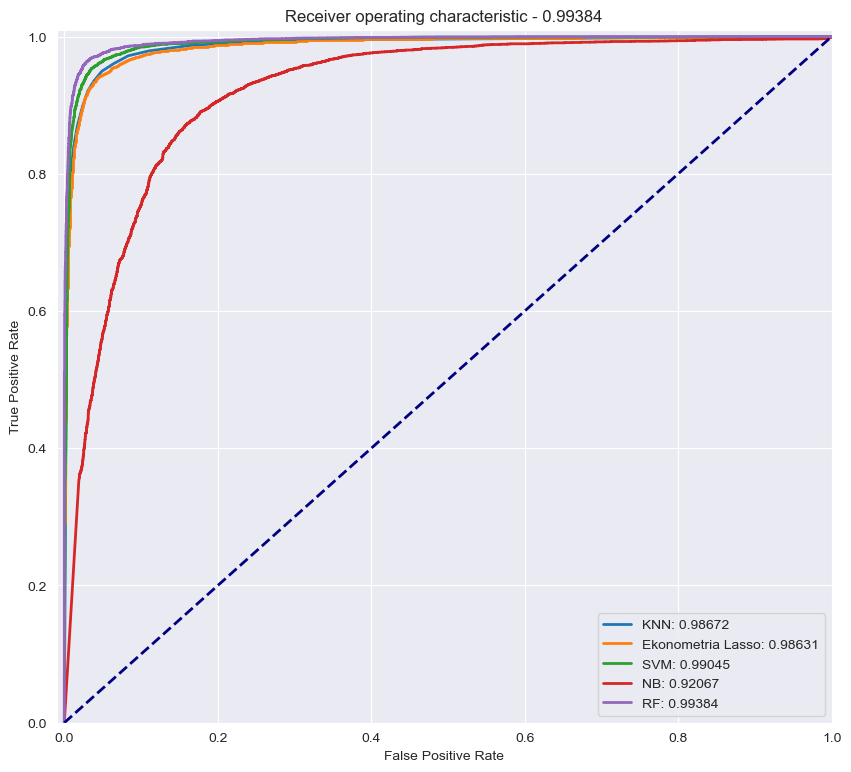

In [246]:
res2plot = []
true = df.status.sort_index()
for result in [modelkNN, modelEkonometria2, modelSVM, modelNB, modelRF]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))

# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

# XGBoost

In [122]:
import xgboost as xgb
import time
from operator import itemgetter

def run_xgb(train, validate, features, target, # argumenty obowiązkowe
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hiperparametry
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hiperparametry
            rate_drop = 0.2, skip_drop=0.5, # hiperparametry
            num_boost_round = 1000, early_stopping_rounds = 50, # hiperparametry
            debug=True, eval_metric= ["auc"], objective = "binary:logistic", # konfiguracja
            seed=2017, booster = "gbtree", tree_method="exact", grow_policy="depthwise"): # konfiguracja

    start_time = time.time()
    paramList= ['eta', 'max_depth',
                'subsample', 'colsample_bytree', 'colsample_bylevel',
                'lambdaX', 'alpha', 'gamma', 'min_child_weight',
                'num_boost_round', 'early_stopping_rounds',
                'rate_drop', 'skip_drop',
                'eval_metric', 'objective',
                'seed', 'booster', 'tree_method', 'grow_policy']

    # Stworzenie słownika do przekazania do XGB
    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(debug):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    # Automatyczne przekazanie liczby klas dla wielu poziomów klasyfikacji
    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1

    # XGB wymaga w słowniku parametrów słowa kluczowego lambda, poniżej workaround
    params["lambda"]=lambdaX

    # Przekształcenie zbiorów do struktury DMatrix
    # Struktura danych DMatrix pozwala na efektywne tworzenie drzew
    dtrain = xgb.DMatrix(train[features], train[target], )
    dvalid = xgb.DMatrix(validate[features], validate[target])

    # Stworzenie listy zbiorów do ealuacji
    evals = [(dtrain, 'train'), (dvalid, 'valid')]

    # Stworzenie zmiennej słownikowej do przekazania
    train_history = dict()

    # Uruchomienie algorytmu trenującego
    gbm = xgb.train(params, dtrain,
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)

    # Obliczenai statystyk i dodatkowych wartości
    score = gbm.best_score

    # Przekształcenie historii trenowania do Pandas Data Frame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    # Zapis przewidywanych wartości dla zbioru walidacyjnego dla najlepszej (z punktu widzenia walidacji) iteracji
    #trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    #testPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)
    best_iter = gbm.best_iteration  # or model.best_ntree_limit for older versions
    trainPred = gbm.predict(dtrain, iteration_range=(0, best_iter))
    testPred = gbm.predict(dvalid, iteration_range=(0, best_iter))
    # Przygotowanie posortowanej listy dla wazności zmiennych, zamaist słownika
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        # Skorzystanie z wbudowanej funkcji wizualizującej waznośc zmiennych
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
    return score, trainPred, testPred, train_history, impFig, imp

In [123]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Przygotujmy prosty wrapper
def CVTestXGB(nFolds = 5, randomState=2025, features=features, debug=False, *args, **kwargs):

    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []

    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []

    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []

    # Przygotujmy listę historii
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())

        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())

        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df[target].iloc[train], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)

        trainResults.append(trainScore)
        testResults.append(testScore)

        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1

        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)

    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

In [124]:
import warnings

# Ignore only the "Parameters: {...} are not used" warning from xgboost.callback
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module=r"xgboost\.callback"
)

Spójrzmy najpierw na AUC w zależności od maksymalnej głębokości drzewa:

4 0.9946154850039306
5 0.9950017144564145
6 0.9951718125792786
7 0.9953636655674284
8 0.9954390246910926
9 0.9953311957367046
10 0.9953880232666098
11 0.9953120437654878


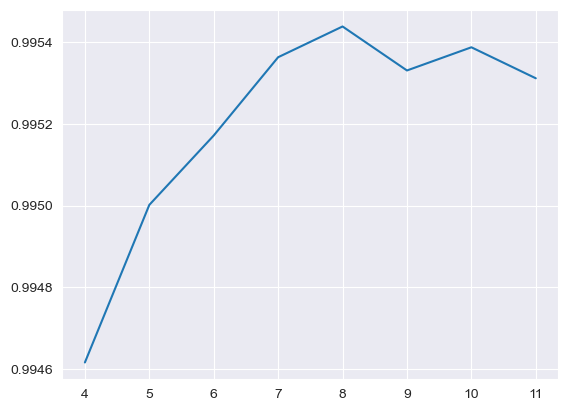

In [133]:
rang = range(4,12)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(max_depth=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

Wartość 8 będzie najlepsza. Teraz zobaczmy jak procent obserwacji wziętych do budowy drzewa wpływa na AUC:

2 0.9947494560639576
3 0.9951358029724696
4 0.9951508375183448
5 0.9953423386745776
6 0.9953835816879165
7 0.9954390246910926
8 0.9954785455042547
9 0.9954376569288442


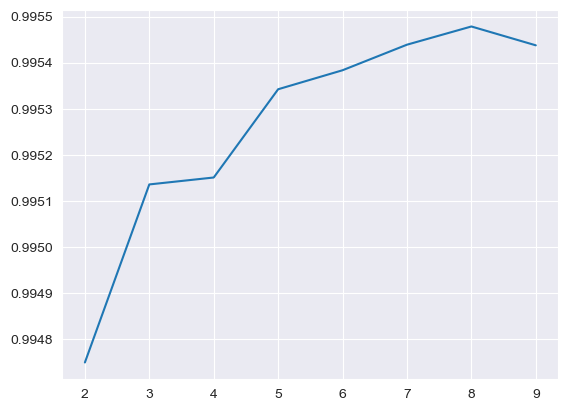

In [134]:
rang = range(2,10)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=8, subsample = x/10)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

Najlepszy będzie udział 80%. Teraz spójrzmy na procent kolumn wziętych do budowy drzewa:

2 0.9954907650658507
3 0.9955708602716186
4 0.9955158794313906
5 0.9954808197142627
6 0.9953958411399046
7 0.9954785455042547
8 0.995411497494508
9 0.9953649328716143


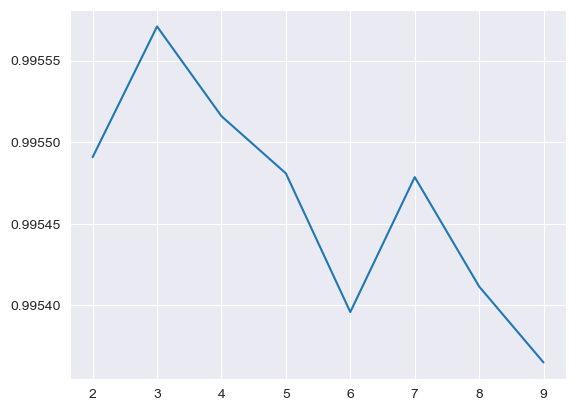

In [127]:
rang = range(2,10)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=8, subsample = 0.8, colsample_bytree = x/10)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

Poniższy wykres wskazuje, że najepiej będzie gdy drzewo będzie miało dostęp do 30% kolumn. Jak powinien się kształtować parametr lambda?

0 0.9955901125215176
1 0.9955708602716186
4 0.9953417518773868
9 0.9952331729184621
16 0.9949999398707952
25 0.9948389967578795
36 0.9946347259303598
49 0.994344978500324


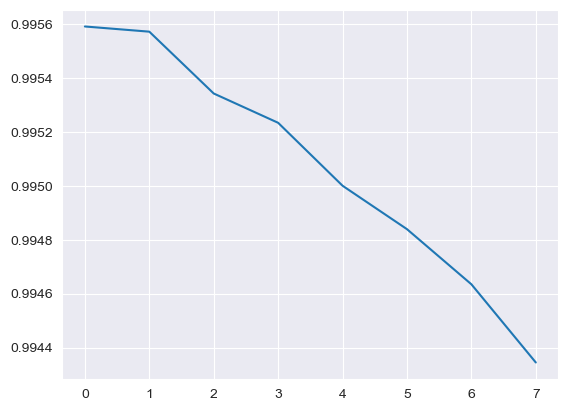

In [135]:
rang = range(0,8)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=8, subsample = 0.8, colsample_bytree = 0.3, lambdaX=x**2)
    print(x**2, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

Tutaj z kolei mamy malejące AUC wraz ze wzrostem lambdy. Finalnie, spójrzmy na gammę:

0.01 0.9955574005456459
0.1 0.9953939625948831
0.5 0.9954455958593433
1 0.9952716315017772
2 0.9951630272690022
4 0.9946906231411384
6 0.9943195768385868
8 0.993816056912145
10 0.9933902302219254
15 0.9920947120984118


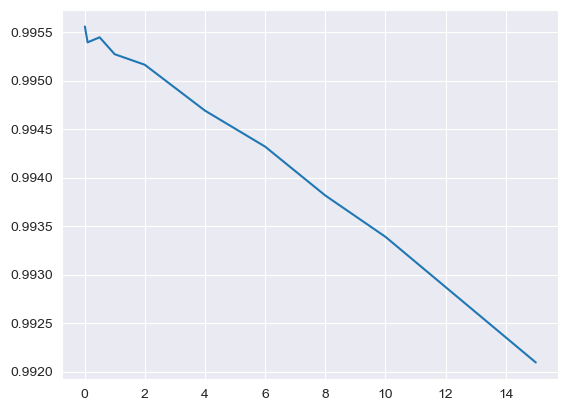

In [129]:
rang = [0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 15]
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=8, subsample = 0.8, colsample_bytree = 0.3, lambdaX=0, gamma=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

Jeszcze rozważmy parametr lambda = 1. Różnica między AUC dla lambdy=1 i lambdy=0 była niewielka - uwzględnienie jej w modelu mogłoby pomóc z adresowaniem overfittingu.

0.01 0.9954400777369152
0.1 0.9954521674243807
0.5 0.9953881659022017
1 0.9952745240093988
2 0.9949682526400014
4 0.9947094188366148
6 0.9941961122927292
8 0.9937842107097007
10 0.9930312754237132
15 0.9916259642101284


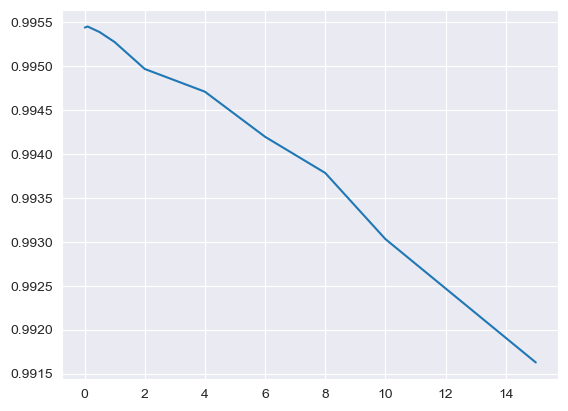

In [136]:
rang = [0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 15]
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=8, subsample = 0.8, colsample_bytree = 0.3, lambdaX=1, gamma=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

Tak więc nasz ręcznie dobrany model CVTestXGB(max_depth=8, subsample = 0.8, colsample_bytree = 0.3, lambdaX=0, gamma=0.01) będzie miał AUC równe 0,99556. Z uwzględnieniem lambdy=1, AUC = 0,99544.
Sprawdźmy czy losowanie parametrów pomoże nam znaleźć lepszy model:

In [101]:
import random
random.seed(2025)
results=[]
paramList = []
for x in range(100):
    params = (random.randint(3, 12), random.uniform(0.1, 0.9), random.uniform(0.1, 0.9), random.uniform(0, 10), random.uniform(0, 10))
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=params[0],
        subsample = params[1],
        colsample_bytree = params[2],
        lambdaX=params[3],
        gamma=params[4])
    if x%10==0:
        print(x)
    #print(np.mean(testResults), params)
    results.append(np.mean(testResults))
    paramList.append(params)

maxRes = []
for i in range(1, len(paramList)):
    maxRes.append(max(results[0:i]))
imp = list(zip(results, paramList))
imp.sort(reverse=True)
for row in imp[0:10]:
    print(row)

(np.float64(0.994736896856927), (12, 0.7298129527380824, 0.8099029346384738, 0.010720581293961473, 0.5688698431701755))
(np.float64(0.9946628941094918), (9, 0.7343568126561864, 0.42394030397584126, 9.260538430628271, 1.165824389934429))
(np.float64(0.9945440636488435), (7, 0.7447206542575892, 0.32791216569154824, 3.511614574738766, 2.7348252978932797))
(np.float64(0.9945379068167404), (8, 0.716700389033423, 0.8325071002487618, 8.780750138938293, 1.3694195062122017))
(np.float64(0.994475323229446), (10, 0.5593321526825049, 0.3807992791652912, 4.948888479269142, 2.111495065911643))
(np.float64(0.9944536648068685), (5, 0.5207479124633347, 0.7533982166563076, 2.0106401313187297, 2.165199575883193))
(np.float64(0.994425830565787), (7, 0.8624534782091285, 0.2875271936348527, 0.877153849849629, 4.551879258972669))
(np.float64(0.9944173879452446), (9, 0.40404319077352857, 0.7743312009443722, 1.6724031912497772, 2.2168282354221858))
(np.float64(0.9942142527902099), (6, 0.3564094603232253, 0.739

Jak widać, AUC najlepszego wylosowanego modelu jest znacznie niższe. Może podejście drugie pomoże?

In [117]:
import random
import numpy as np
from itertools import product

# Ustawiamy ziarno dla powtarzalności
random.seed(2025)

# 1) Definicja zakresów parametrów
max_depth         = list(range(4, 12))                 # np. 4,5,...,11
subsample         = [x/10 for x in range(2, 10)]       # 0.2, 0.3, ... 0.9
colsample_bytree  = [x/10 for x in range(2, 10)]       # 0.2, 0.3, ... 0.9
lambdaX_raw       = list(range(0, 8))                  # będziemy podnosić do kwadratu
gamma             = [0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 15]

# 2) Pełna siatka wszystkich kombinacji
param_grid = list(product(
    max_depth,
    subsample,
    colsample_bytree,
    lambdaX_raw,
    gamma
))

# 3) Losujemy 250 unikalnych zestawów
sampled_params = random.sample(param_grid, 100) if len(param_grid) > 100 else param_grid

results    = []
total      = len(sampled_params)

# 4) Pętla ewaluacyjna
for idx, (md, subs, col, lam_raw, gam) in enumerate(sampled_params, start=1):
    lam2 = lam_raw ** 2   # kwadratujemy lambda

    trainR, testR, preds, indices, hists = CVTestXGB(
        max_depth         = md,
        subsample         = subs,
        colsample_bytree  = col,
        lambdaX           = lam2,
        gamma             = gam
    )

    score = np.mean(testR)
    # zachowujemy wynik i parametry (tu zapisujemy już lam2, bo faktycznie trafiło do modelu)
    results.append((score, (md, subs, col, lam2, gam)))

    # progres
    if idx % 10 == 0 or idx == total:
        print(f"Przetworzono {idx}/{total} kombinacji")

# 5) Sortowanie i wyświetlenie top 10
results.sort(key=lambda x: x[0], reverse=True)
print("\nTop 10 najlepszych konfiguracji:")
for score, params in results[:10]:
    print(f"score={score:.4f} \t params={params}")


Przetworzono 10/100 kombinacji
Przetworzono 20/100 kombinacji
Przetworzono 30/100 kombinacji
Przetworzono 40/100 kombinacji
Przetworzono 50/100 kombinacji
Przetworzono 60/100 kombinacji
Przetworzono 70/100 kombinacji
Przetworzono 80/100 kombinacji
Przetworzono 90/100 kombinacji
Przetworzono 100/100 kombinacji

Top 10 najlepszych konfiguracji:
score=0.9954 	 params=(8, 0.8, 0.2, 1, 0.01)
score=0.9953 	 params=(8, 0.5, 0.4, 0, 0.1)
score=0.9953 	 params=(10, 0.8, 0.2, 0, 1)
score=0.9953 	 params=(9, 0.4, 0.3, 0, 0.1)
score=0.9953 	 params=(10, 0.8, 0.5, 1, 0.5)
score=0.9951 	 params=(11, 0.8, 0.2, 4, 0.5)
score=0.9951 	 params=(8, 0.9, 0.3, 16, 0.01)
score=0.9951 	 params=(8, 0.6, 0.4, 9, 0.01)
score=0.9951 	 params=(11, 0.6, 0.2, 4, 0.5)
score=0.9950 	 params=(10, 0.9, 0.3, 25, 0.01)


In [139]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=8, subsample = 0.8, colsample_bytree = 0.2, lambdaX=1, gamma=0.01)
print(np.mean(testResults))

0.995392456209834


Tutaj wyniki są znacznie bliższe - najlepszy model stąd jest trochę gorszy w porównaniudo pierwszych dwóch modelów

Skłaniałbym się do wyboru modelu z lambdą = 1, ponieważ jest ona niezerowe, co pozwala częściowo zaadresować możliwy problem overfittingu.

In [247]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=8, subsample = 0.8, colsample_bytree = 0.3, lambdaX=1, gamma=0.01)
print(np.mean(testResults))

modelXGB = {
    "name":"XGB",
    "description":"Model XGB",
    "specification":'max_depth=8, subsample = 0.8, colsample_bytree = 0.3, lambdaX=1, gamma=0.01',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9954400777369152


In [248]:
import pickle

# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_XGB_1.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelXGB, fp)

In [249]:
with open("model_ekonometria_2.p", "rb") as fp:
    modelEkonometria2 = pickle.load(fp)

with open("model_svm_1.p", "rb") as fp:
    modelSVM = pickle.load(fp)

with open("model_kNN_1.p", "rb") as fp:
    modelkNN = pickle.load(fp)

with open("model_NB_1.p", "rb") as fp:
    modelNB = pickle.load(fp)

with open("model_RF_1.p", "rb") as fp:
    modelRF = pickle.load(fp)

with open("model_XGB_1.p", "rb") as fp:
    modelXGB = pickle.load(fp)

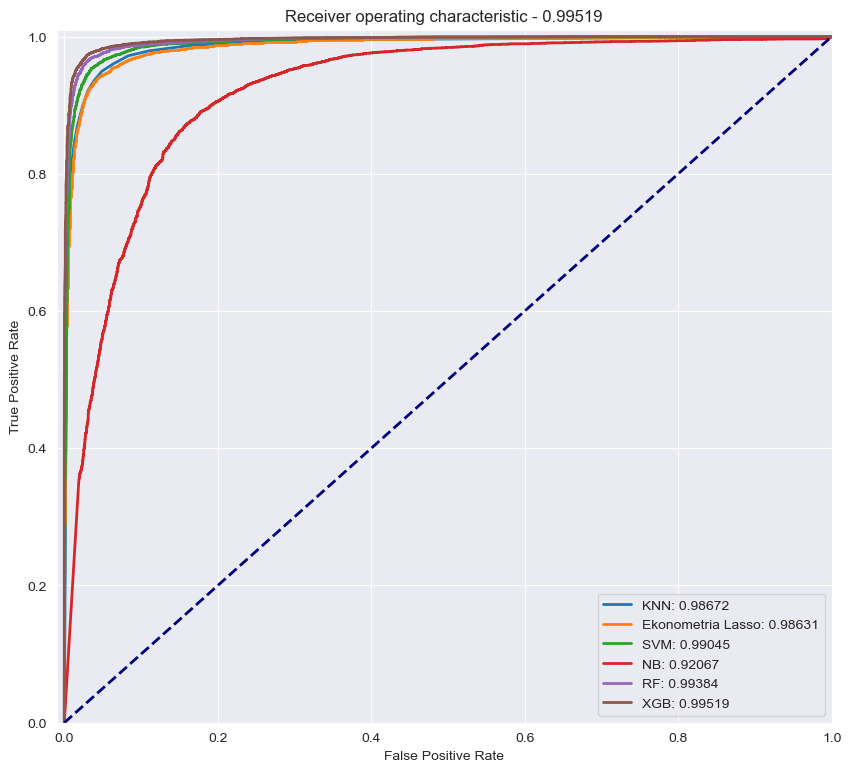

In [250]:
res2plot = []
true = df.status.sort_index()
for result in [modelkNN, modelEkonometria2, modelSVM, modelNB, modelRF,  modelXGB]:
# Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))

# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

# Sieci neuronowe

In [158]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

class PtDataset(Dataset):
    def __init__(self, X, y):
        '''Przyjmujemy dane X (macierz zmiennych objaśniających) oraz y (macierz) w formacie numpy'''
        # Przerabiamy z numpy na Torch i wpisujemy do obiektu dataset pod X i y
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = self.X[idx]
        target = self.y[idx]
        return features, target

In [159]:
X_train, X_test, y_train, y_test = train_test_split(df, df.status, test_size=0.3, random_state=2025)
trainDataset = PtDataset(X_train[features].values, X_train[[target]].values)
testDataset = PtDataset(X_test[features].values, X_test[[target]].values)

In [160]:
def create_network(n_layers, n_inputs, n_inputs_init, dropout, activation, **kwargs):
    '''n_layers : int - liczba warstw w sieci
        n_inputs = lista o takiej długości jak n_layers informująca o liczbie inputów w każdj warstwie
        dropout : float (0-1) | list - albo wspólna wartośc dla wszystkich warstw albo lista o długości n_layers
        activation: string | list - albo wspólna dla wszysktich warstw albo lista'''
    network_elements = []
    for k in range(n_layers):
        if k == 0:
            network_elements.append(nn.Linear(n_inputs_init, n_inputs[k]))
        else:
            network_elements.append(nn.Linear(n_inputs[k - 1], n_inputs[k]))

        if type(dropout) == float:
            drop = dropout
        else:
            drop = dropout[k]
        if drop > 0:
            network_elements.append(nn.Dropout(drop))

        act_dict = {
            "ReLU": nn.ReLU,
            "PReLU": nn.PReLU,
            "mish": nn.Mish,
            "tanh": nn.Tanh,
            "sigmoid": nn.Sigmoid,
            "swish": nn.SiLU,

        }

        if type(activation) == str:
            act = activation
        else:
            act = activation[k]
        network_elements.append(act_dict[act]())
    network_elements.append(nn.Linear(n_inputs[-1], 1))
    network_elements.append(nn.Sigmoid())
    return nn.Sequential(*network_elements)


def eval_loader(ptLoader, model):
    all_preds = []
    all_trues = []
    for X_batch, y_batch in ptLoader:
        y_pred = model(X_batch)
        all_preds.append(y_pred.detach().numpy())
        all_trues.append(y_batch.detach().numpy())

    all_preds = np.concatenate(all_preds).flatten()
    all_trues = np.concatenate(all_trues).flatten()
    return all_preds, all_trues


def train_network(model, trainDataset, testDataset, n_epoch=10, lfn="BCELoss", opt="Adam", batch_size=100, **kwargs):
    # Przygotowujemy Loadery pytocha do podawania danych
    # Dla zbioru treningowego ważny jest batchsize oraz shuffle
    trainLoader = DataLoader(trainDataset, shuffle=True, batch_size=batch_size)

    # Dla zbioru testowego na CPU pewnie można wsadzić jako batchsize cały zbiór
    # W zbiorze testowym batchsize nie ma znaczenia
    testLoader = DataLoader(testDataset, batch_size=X_test.shape[0], shuffle=False)
    # Wybieramy odpowiednią funkcję straty dla naszego problemu
    loss_fn_dict = {
        "BCELoss": nn.BCELoss,
    }

    opt_dict = {
        "SGD": torch.optim.SGD,
        "Adam": torch.optim.Adam,
    }
    # loss_fn = nn.CrossEntropyLoss()
    # Klasyfikacja binarna potrzebuje Binominal Cross entropy BCELoss
    loss_fn = loss_fn_dict[lfn]()

    # Wybieray odpowiedni optymalizator
    opt_kwargs = dict()
    for opt_arg in ["lr"]:
        if opt_arg in kwargs:
            opt_kwargs[opt_arg] = kwargs[opt_arg]

    optimizer = opt_dict[opt](model.parameters(), **opt_kwargs)

    # Trenujemy model
    n_epochs = n_epoch

    train_history = dict()
    train_auc = []
    test_auc = []
    best_test_res = 0
    for epoch in range(n_epochs):
        # W każdej epoce
        # Przestawiamy model w tryb treningowy
        model.train()
        #         print(epoch)

        # Następnie usimy przejść przez batche z naszego loader
        for X_batch, y_batch in trainLoader:
            # Przepuszczamy batch przez model
            # Forward pass
            y_pred = model(X_batch)

            # Liczymy stratę w tym przebiegu na tym batchu
            loss = loss_fn(y_pred, y_batch)

            # Najpiew zerujemy gradienty w kroku
            optimizer.zero_grad()

            # Backward pass
            loss.backward()

            # Krok - aktualizacja parmetrów z optymalizatora na podstawie gradientu
            optimizer.step()

        # Na potrzeby diagnostyki robimy ealuacje w każdej epoce
        # Zieniay mdoel w tryb ewaluacji
        model.eval()
        # Tworzymy pythonowe listy na predykcje
        all_preds, all_trues = eval_loader(testLoader, model)
        auc = roc_auc_score(all_trues,
                            all_preds)
        test_auc.append(auc)
        if auc > best_test_res:
            best_preds = all_preds
            best_auc = auc
        #         print(f"Model auc: {round(auc, 3)}")

        all_preds, all_trues = eval_loader(trainLoader, model)
        auc = roc_auc_score(all_trues,
                            all_preds)
        train_auc.append(auc)

    train_history["train_auc"] = train_auc
    train_history["test_auc"] = test_auc
    return train_history, best_preds, best_auc

In [161]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Przygotujmy prosty wrapper
def CVTestNN(nFolds=5, randomState=2025, features=features, debug=False, *args, **kwargs):
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapamiętujemy wyniki zbioru treningowego i testowego
    testResults = []
    trainResults = []

    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []

    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []

    # Przygotujmy listę historii
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        trainDataset = PtDataset(df.iloc[train][features].values, df.iloc[train][[target]].values)
        testDataset = PtDataset(df.iloc[test][features].values, df.iloc[test][[target]].values)

        model = create_network(**kwargs)
        train_hisotry, best_preds, best_auc = train_network(model, trainDataset, testDataset, **kwargs)
        #         # Przygotowanie estymatora
        #         score, trainPred, testPred, history = net(df.iloc[train], df.iloc[test], features, target,
        #                                                             debug=False, *args, **kwargs)

        #         # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(best_preds.copy())

        #         # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())

        #         # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        #         trainScore = roc_auc_score(df[target].iloc[train], trainPred)
        #         testScore = roc_auc_score(df[target].iloc[test], testPred)

        #         trainResults.append(trainScore)
        testResults.append(best_auc)

        hists.append(train_hisotry)
        fold += 1

        if debug:
            print("Valid AUC:", best_auc)

    return testResults, predictions, indices, hists




UWAGA! - dla poniższych modeli seed nie działa prawidłowo - nie można odtworzyć modelu. Należy mieć to na uwadze, patrząc na wyniki i optymalne parametry.

Będziemy patrzeć na modele z 2 i 3 ukrytymi sieciami:

Zaczynając od spojrzenia na wielkość batch size, czyli liczby próbek podawanych jednocześnie, przed aktualizacją parametrów

In [162]:
batchSizes = [50, 100, 200, 500]

for batch in batchSizes:
    testResults, predictions, indices, hists = CVTestNN(nFolds=5, randomState=2025, features=features, batch_size = batch, debug=False,
                                                        n_layers=2, n_inputs=[100, 40], n_inputs_init=len(features),
                                                        dropout=0.2, activation="ReLU",
                                                        n_epoch=30, lfn="BCELoss", opt="Adam")
    print(np.mean(testResults))

0.991179070999789
0.9920170966401566
0.99157739714377
0.9917444633984722


Najlepszy wynik jest dla wartości 100 - czy w przypadku 3 ukrytych warstw będzie podobnie?

In [167]:
batchSizes = [50, 100, 200, 500]

for batch in batchSizes:
    testResults, predictions, indices, hists = CVTestNN(nFolds=5, randomState=2025, features=features, batch_size = batch, debug=False,
                                                        n_layers=3, n_inputs=[100, 40, 20], n_inputs_init=len(features),
                                                        dropout=0.2, activation="ReLU",
                                                        n_epoch=30, lfn="BCELoss", opt="Adam")
    print(np.mean(testResults))

0.9916849856166609
0.9914738951621154
0.9919880546775317
0.9918917822209569


Tutaj lepiej pozostać przy batchu równym 200.

Teraz spójrzmy na dropout rate:

In [169]:
dropout = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8]

for drop in dropout:
    testResults, predictions, indices, hists = CVTestNN(nFolds=5, randomState=2025, features=features, batch_size = 100, debug=False,
                                                        n_layers=2, n_inputs=[100, 40], n_inputs_init=len(features),
                                                        dropout=dropout, activation="ReLU",
                                                        n_epoch=30, lfn="BCELoss", opt="Adam")
    print(np.mean(testResults))

0.9902468907172862
0.9901876098573938
0.9911743209045876
0.9910880951352432
0.9910360259433675
0.9906707103135295


In [170]:
dropout = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8]

for drop in dropout:
    testResults, predictions, indices, hists = CVTestNN(nFolds=5, randomState=2025, features=features, batch_size = 200, debug=False,
                                                        n_layers=3, n_inputs=[100, 40, 20], n_inputs_init=len(features),
                                                        dropout=drop, activation="ReLU",
                                                        n_epoch=30, lfn="BCELoss", opt="Adam")
    print(np.mean(testResults))

0.9903478211652995
0.9906870400663094
0.9918471759453518
0.9917426457237649
0.9913668291779276
0.9894663039677456


W modelu z dwoma i trzema ukrytymi warstwami opłaca się wygaszać 40% neuronów. Wygaszanie odbywa się na każdej z ukrytych warstw - a co jeśli na każdej z nich byłoby ono inne?

In [173]:
testResults, predictions, indices, hists = CVTestNN(nFolds=5, randomState=2025, features=features, debug=False,
                                                    n_layers=2, n_inputs=[100, 40], n_inputs_init=len(features),
                                                    dropout=[0.4, 0], activation="ReLU", batch_size = 100,
                                                    n_epoch=20, lfn="BCELoss", opt="Adam")
print(np.mean(testResults))

0.9916620375354828


In [172]:
testResults, predictions, indices, hists = CVTestNN(nFolds=5, randomState=2025, features=features, debug=False,
                                                    n_layers=3, n_inputs=[100, 40, 20], n_inputs_init=len(features),
                                                    dropout=[0.4, 0.2, 0], activation="ReLU", batch_size = 200,
                                                    n_epoch=30, lfn="BCELoss", opt="Adam")
print(np.mean(testResults))

0.9914793907214147


Nie wydaje się to polepszać modelu - zostańmy przy stałych wartościach.
Teraz spróbujmy znaleźć lepsze parametry modelu przez losowanie - do losowanych wartosci dodamy jeszcze parametr n_epoch, czyli liczbę powtórzeń uczenia całym zbiorem danych treningowych

In [219]:
import random
import numpy as np
from itertools import product

# 0) Powtarzalność
random.seed(2025)

# 1) Definicja zakresów parametrów
batch_size  = [50, 100, 200, 500]
n_layers    = [2, 3]
n_epoch     = [20, 30, 40, 50]
dropout     = [i/10 for i in range(0, 9)]    # 0.0, 0.1, …, 0.8

# 2) Pełna siatka wszystkich kombinacji
param_grid = list(product(
    batch_size,
    n_layers,
    n_epoch,
    dropout
))
total = len(param_grid)

# 3) Losujemy do 250 unikalnych zestawów
sampled_params = (
    random.sample(param_grid, 100)
    if total > 100
    else param_grid
)

# baza do wycinania `n_inputs`
_base_inputs = [100, 40, 20]

results = []

# 4) Pętla ewaluacyjna
for idx, (batch, layers, epoch, drop) in enumerate(sampled_params, start=1):
    # dynamiczne n_inputs
    n_inputs = _base_inputs[:layers]

    testResults, predictions, indices, hists = CVTestNN(
        n_inputs_init = len(features),
        activation    = "ReLU",
        lfn           = "BCELoss",
        opt           = "Adam",
        batch_size    = batch,
        n_layers      = layers,
        n_epoch       = epoch,
        dropout       = drop,
        n_inputs      = n_inputs
    )

    score = np.mean(testResults)
    #print(score)
    results.append((score, (batch, layers, epoch, drop)))

    # progres co 10 iteracji
    if idx % 10 == 0 or idx == len(sampled_params):
        print(f"Przetworzono {idx}/{len(sampled_params)}")

# 5) Sortowanie i wyświetlenie top–10
results.sort(key=lambda x: x[0], reverse=True)
print("\nTop 10 najlepszych konfiguracji:")
for score, params in results[:10]:
    print(f"score={score:.4f}\tparams={params}")

Przetworzono 10/100
Przetworzono 20/100
Przetworzono 30/100
Przetworzono 40/100
Przetworzono 50/100
Przetworzono 60/100
Przetworzono 70/100
Przetworzono 80/100
Przetworzono 90/100
Przetworzono 100/100

Top 10 najlepszych konfiguracji:
score=0.9923	params=(200, 2, 30, 0.3)
score=0.9923	params=(100, 3, 50, 0.4)
score=0.9923	params=(100, 3, 50, 0.6)
score=0.9922	params=(100, 2, 40, 0.4)
score=0.9922	params=(500, 2, 40, 0.0)
score=0.9922	params=(50, 3, 30, 0.5)
score=0.9921	params=(50, 3, 40, 0.4)
score=0.9920	params=(200, 2, 50, 0.5)
score=0.9920	params=(200, 3, 30, 0.2)
score=0.9920	params=(50, 2, 40, 0.4)


Najlepszy wylosowany model ma lepsze AUC w porównaniu do wcześniej sprawdzanych modeli.

In [183]:
testResults, predictions, indices, hists = CVTestNN(nFolds=5,features=features, batch_size = 200, debug=False,
                                                           n_layers=2, n_inputs=[100, 40], n_inputs_init=len(features), dropout=0.3,
                                                           activation="ReLU", n_epoch=30, lfn="BCELoss", opt="Adam")
print(np.mean(testResults))

modelNN = {
    "name":"NNet",
    "description":"Model NN",
    "specification":'features=features, n_layers=2, n_inputs=[100, 40], epochs = 30, batchSize=200, optimizer="Adam", activation="ReLu", dropout_rate=0.3, debug=False',
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9921288157387025


In [185]:
import pickle

# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_NN_1.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelNN, fp)

# Finalne porównanie wyników

In [251]:
with open("model_ekonometria_2.p", "rb") as fp:
    modelEkonometria2 = pickle.load(fp)

with open("model_svm_1.p", "rb") as fp:
    modelSVM = pickle.load(fp)

with open("model_kNN_1.p", "rb") as fp:
    modelkNN = pickle.load(fp)

with open("model_NB_1.p", "rb") as fp:
    modelNB = pickle.load(fp)

with open("model_RF_1.p", "rb") as fp:
    modelRF = pickle.load(fp)

with open("model_XGB_1.p", "rb") as fp:
    modelXGB = pickle.load(fp)

with open("model_NN_1.p", "rb") as fp:
    modelNN = pickle.load(fp)

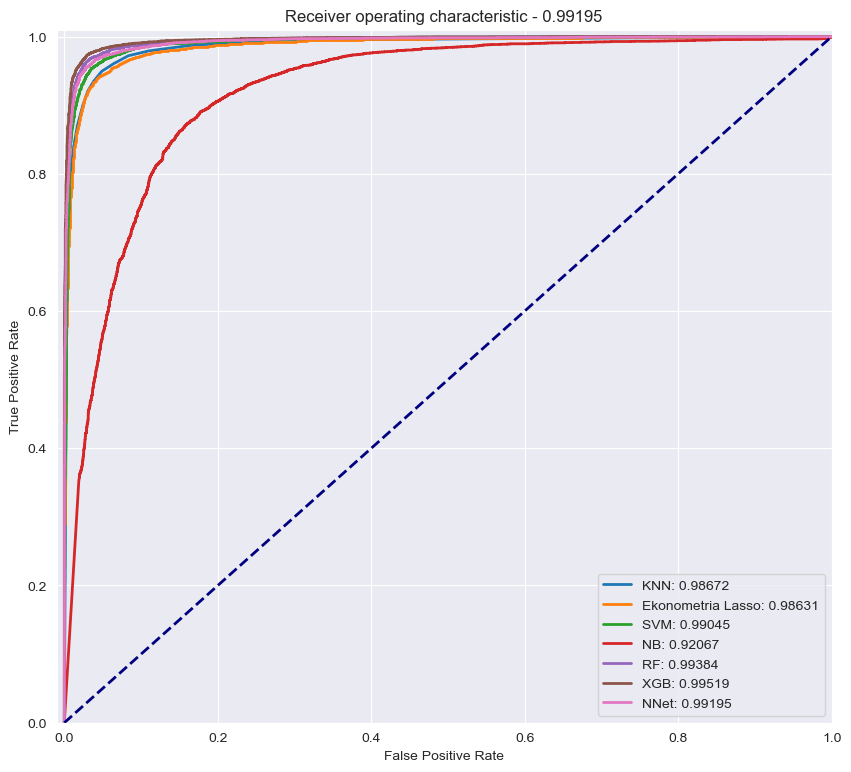

In [253]:
res2plot = []
true = df.status.sort_index()
for result in [modelkNN, modelEkonometria2, modelSVM, modelNB, modelRF,  modelXGB, modelNN]:
    # scalamy wszystkie predykcje i wszystkie indeksy
    all_preds   = np.concatenate(result["predictions"])
    all_indices = np.concatenate(result["indices"])

    # składamy Series z odpowiednimi indeksami
    pred = pd.Series(all_preds, index=all_indices).sort_index()
    res2plot.append((true, pred, result["name"]))

# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

#### Jak widać, najlepszy okazał się model XGBoost, tuż za nim Random Forest i Neural Network. Wyraźnie gorzej radzi sobie Naive Bayes. AUC w reszcie modeli oscyluje koło 0,99.